In [1]:
### Application: ECG-Modeling
# Work in progress

In [2]:
import numpy as np
import math
from scipy import integrate, ndimage, signal
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import os, sys
import copy
sys.path.append(os.path.abspath(os.path.join('../../..')))
import pandas as pd
import datetime
from functools import partial
import tensorflow as tf
import pickle
import glob
import re
import time
import shutil
from IPython.display import Image
from IPython.core.display import HTML 

2022-09-22 16:34:16.726937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from bayesflow.forward_inference import GenerativeModel, Prior, Simulator
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/rene/Bf_ecg/BayesFlow/bayesflow/forward_inference.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Introduction: Synthetically Modeling ECG with BayesFlow

This notebook serves as an introduction to the BayesFlow library by applying it to a mathematical model capable of producing a synthetic electrocardiogram (ECG). The goal is to learn to predict the distribution of various model parameters from a simulated ECG signal. 

Our tutorial begins with a very brief introduction to the ECG signal, a time series of frequencies representing the depolarization and repolarization of various portions of the heart in the course of each heartbeat, and the way in which the simulation model attempts to reproduce its properties. We then turn to an implementation of this model, which is in turn fed into an appropriate BayesFlow architecture in order to learn the parameter distributions. We conclude by evaluating the performance of our BayesFlow.

Here is a segment of ECG representing a single heartbeat:

In [4]:
Image(url= "https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg", width=500, height=500)
# (Created by Agateller (Anthony Atkielski), converted to svg by atom., Public domain, via Wikimedia Commons)

The local maxima and minima of the signal characterize five waves labelled P,Q,R,S and T. Their relative shape and size can be used by clinicians to draw conclusions about the cardiac health of a patient.

In their 2003 paper, McSherry et al. proposed a model for generating a synthetic ECG signal using a system of ordinary differential equations (ODEs). A brief explanation of this system is given below, with a focus on its connection to the generated ECG signal (i.e. how it works), whereas the motivation behind the system (i.e. why it works) is largely ignored.

The solution $z$ of the third differential equation in the system represents the actual ECG signal as a function of time, whereas the solutions $x$ and $y$ of the first two equations have to do with the duration of each heartbeat (note that we are omitting the argument $t$ throughout, writing e.g. $x$ for $x(t)$):

$$\begin{cases}
\dot{x} = \alpha(x,y) x - \omega y\\
\dot{y} = \alpha(x,y) y + \omega x\\
\dot{z} = -\sum_{i \in {P,Q,R,S,T}} a_i \Delta \theta_i(y,x) \exp \left( \frac{-(\Delta \theta_i(y,x))^2}{2b_i^2} \right)-(z-z_0)
\end{cases}$$

where

$$ \alpha(x(t),y(t)) = 1 - \sqrt{x^2(t)+y^2(t)} \qquad \Delta \theta_i(y(t),x(t)) = (\text{atan2}(y(t),x(t))-\theta_i) \mod 2\pi \qquad z_0(t) = 0.005 \sin(2 \pi t f_2)$$

The parameters $a=(a_0, ..., a_4), b=(b_0, ..., b_4)$ and $\theta = (\theta_0, ..., \theta_4)$ are time-independent five-dimensional vectors which primarily determine the structure of the waves comprising the ECG signal, which is why their entries are indexed with the names of the waves. $a$ determines the amplitude of each wave (i.e. how low/high is minimum/maximum is), $b$ determines the width of each wave, and $\theta$ determines the position of each wave within a heartbeat.

$\omega$ is a time-dependent function responsible for modelling changes in duration between two heartbeats. The biological processes which it models and its mathematical construction exceed the scope of this tutorial, however. Here, it is treated as a time-independent constant. Thus, the simplified model below generates a sequence of largely identical heartbeats.

Changes between heartbeats only result from a wandering baseline frequency (implemented via $z_0$, which contains the (constant) respiratory frequency $f_2$) and noise added to the simulated ECG signal in order to simulate measurement errors.

In order to specify the model, $\theta$, $a$ and $b$ are given default values which will then be varied in order to generate different simulations. They are grouped together in the params_ODE dictionary below, along with the (unvarying) respiratory frequency $f_2=0.25$.

The simulation itself requires a variety of internal parameters. Some (e.g. the initial value pos_0) pertain to the numerical solution of the ODE system (which employs a standard Runge-Kutta method, the socalled Dormand-Prince method), others have to do with the specific nature of modeling a signal corresponding to measurements over time (e.g. the model-internal sampling frequency, sf_int, and the sampling frequency of the synthetic ECG output, sf_ecg), and a few correspond to biological quantities (e.g. the mean heartrate, heartrate_mean). All simulation-related parameters are compiled into a dictionary (params_sim) below.

Of these, the signal duration and the sampling frequencies are kept fixed in this tutorial, because this ensures a signal of constant length in each run of the simulator, which is a prerequisite for the chosen (convolutional) neural architecture to function. The mean heartrate, by contrast, is varied alongside the ODE parameters. A specific mean heartrate requires a rescaling of the positional and width parameters $\theta$ and $b$, so these parameters, at least, are not independent.

We next turn to the implementation of our ECG simulation model, which begins by initializing our parameters.

### 1: Implementing the ECG Model

Much of the implementation below is inspired by McSharry et al.'s (2003) own work ( https://github.com/neuropsychology/NeuroKit ). Several changes were made with readability in mind, however: our code is packaged into a greater number of individual functions, and our variable names are often a bit more explicit than their counterparts in NeuroKit. Where possible, vectorized implementations were chosen over loops in order to speed up computation.

In [5]:
# Function to initialize the various model parameters.
# Details on the role of each parameter are given below.

def initialize_model_parameters(
    theta = np.pi*np.asarray([-1/3,-1/12,0,1/12,0.5]), \
    a = np.asarray([1.2,-5.0,30.0,-7.5, 0.75]), \
    b = np.asarray([0.25, 0.1, 0.1, 0.1, 0.4]), \
    f_2 = 0.25, \
    Nt = 5000, pos_0 = np.asarray([1,0,0.04]), \
    sf_int = 1000, sf_ecg = 250, \
    noise_amp = 0.01, noise_freq = 100, noise_type = 'laplace', \
    heartrate_mean = 60, heartrate_std = 1, \
    duration = 30, N_heartbeats = None
):

    ## ODE system parameters

    # theta: PQRST positions (as specified in the paper)
    # The original Matlab and later NeuroKit implementations use an approximation instead:
    # theta = np.array([-70, -15, 0, 15, 100])/180*np.pi

    # a: PQRST height modifiers
    
    # b: PQRST width modifiers
    
    # f_2: Respiratory frequency

    params_ODE = {'a': a, 'b': b, 'theta': theta, 'f_2': f_2}

    ## Parameters for numeric integration of ODE system

    # Nt: No of samples / times t at which to integrate
    
    # pos_0: Initial value for initial value problem to be solved
    # (other candidate: pos_0 = np.asarray([1, 0, 0]))

    # sf_int: Internal sampling frequency
    
    # sf_ecg: Sampling frequency of ecg; in practice, ECGs can be measured with a 
    # variety of sampling frequencies. 250 and 360 are typical choices, and the
    # lower frequency was selected here to keep the size of simulated data samples
    # as manageable as possible.
    
    # noise_amp, noise_freq, noise_type: Parameters of additive noise (amplitude, frequency, type)
    
    # heartrate_mean, heartrate_std: Mean and standard deviation of heart rate 
    # (take precedent over number of samples if both are given)
    
    # duration, N_heartbeats: if heartrate_mean and heartrate_std are provided, the duration of the ecg signal
    # or an approximate number of heartbeats must be specified
    # If both are given, duration takes precedent over the approximate number of heartbeats.

    # The dependent parameters used by the numerical method used to solve the system of ODEs
    # are based around max_t, the latest time point t at which the approximate solution is computed:
    # t_span is a list of the first and list t (i.e. 0 and max_t), and t_eval is an array of Nt time points
    # within this range. Note that all of these parameters are always recomputed below, since we systematically
    # supply a mean heartrate.
    max_t = (Nt-1)*(1/sf_int)
    t_span = [0, max_t]
    t_eval = np.linspace(0, max_t, Nt)

    params_sim = {'sf_int': sf_int, 'sf_ecg': sf_ecg, 'Nt': Nt, 'max_t': max_t, \
                  'pos_0': pos_0, 't_span': t_span, 't_eval': t_eval, \
                  'noise_amplitude': noise_amp, 'noise_frequency': noise_freq, 'noise_type': noise_type, \
                  'heartrate_mean': heartrate_mean, 'heartrate_std': heartrate_std, \
                  'duration': duration, 'N_heartbeats': N_heartbeats}

    print("\n Params ODE:")
    print(params_ODE)
    print("\n Params simulation:")
    print(params_sim)
    
    return(params_ODE, params_sim)

In [6]:
# For the sake of convenience, several parameters to do with training are currently
# read from an options file, ecg_options.txt.
with open("ecg_options.txt") as opt_file:
    for line in opt_file.readlines():
        if line.find("Duration") != -1:
            duration = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("n_summary") != -1:
            n_summary = int(re.search(r'\"(.*?)\"', line).group(1))
            print("n_summary: {}".format(n_summary))
            #n_summary = 16
        elif line.find("Depth INN") != -1:
            depth_INN = int(re.search(r'\"(.*?)\"', line).group(1))   
        elif line.find("Number of epochs") != -1:
            epochs = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Iterations per epoch") != -1:
            iterations_per_epoch = int(re.search(r'\"(.*?)\"', line).group(1))
        elif line.find("Batch size") != -1:
            batch_size = int(re.search(r'\"(.*?)\"', line).group(1))   

checkpoint_path = '/home/rene/Bf_ecg/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Sep22'

#'/home/rene/Bf_ecg/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Aug31'

params_ODE, params_sim = initialize_model_parameters()
#params_sim['duration'] = 1
params_sim['duration'] = duration

n_summary: 64

 Params ODE:
{'a': array([ 1.2 , -5.  , 30.  , -7.5 ,  0.75]), 'b': array([0.25, 0.1 , 0.1 , 0.1 , 0.4 ]), 'theta': array([-1.04719755, -0.26179939,  0.        ,  0.26179939,  1.57079633]), 'f_2': 0.25}

 Params simulation:
{'sf_int': 1000, 'sf_ecg': 250, 'Nt': 5000, 'max_t': 4.999, 'pos_0': array([1.  , 0.  , 0.04]), 't_span': [0, 4.999], 't_eval': array([0.000e+00, 1.000e-03, 2.000e-03, ..., 4.997e+00, 4.998e+00,
       4.999e+00]), 'noise_amplitude': 0.01, 'noise_frequency': 100, 'noise_type': 'laplace', 'heartrate_mean': 60, 'heartrate_std': 1, 'duration': 30, 'N_heartbeats': None}


Below, the model is implemented in the spirit of functional programming: the differential equations are organized as combinations of simpler functions. 

Once the ODE system has been defined (ECG_model), an infrastructure for numerically solving it is created, which involves potentially rescaling various parameters based on the mean heartrate. Postprocessing of the signal includes rescaling the signal to lie between $-0.4$ and $+1.2$ Hz and adding noise.

Simulations are run via the generate_ECG function. At its core is the solution of the ODE system, which has to be given an initial value (in the form of the variable pos_0) in order to be uniquely solvable. A standard numerical method for solving systems of ODEs is used here: the Dormand-Prince method ( https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method ), which is the default choice for scipy's integrate.solve_ivp method. 

We also provide a function for visualizing a segment of ECG.

In [7]:
## Implementation of the system of ODEs used in the model

# Helper functions
def alpha(x,y):
    return(1-((x**2 + y**2)** .5))

def delta_theta(x,y,theta):
    return(np.fmod(np.arctan2(y,x)-theta,2*np.pi))
    
def gauss_sum(x,y,a,b,theta):
    d_p = delta_theta(x,y,theta)
    gauss_summands = a*d_p*np.exp(-0.5*((d_p/b)**2))
    return(-np.sum(gauss_summands))

# Note that the paper specifies A = 0.15, but this distorts the entire signal
# rather than just creating baseline wander.
def z_0(t,f_2, A=0.005):
    return(A*np.sin(2*np.pi*f_2*t))

# Handles the logic of whether baseline wander is applied or not
def get_z_zero(baseline_wander):
    if baseline_wander:
        z_zero = z_0
    else:
        z_zero = lambda t, f_2: 0
    return(z_zero)

# Actual system of ODEs
def ECG_model(t, p, T_om, params_ODE, params_sim, omega, z_zero, baseline_wander=False):
    alpha_yx = alpha(p[0],p[1])
    omega_T = omega(t, T_om, params_sim['sf_int'], params_sim['Nt'])
    
    position = [alpha_yx*p[0]-omega_T*p[1], alpha_yx*p[1]+omega_T*p[0], \
                gauss_sum(p[0],p[1],params_ODE['a'],params_ODE['b'],params_ODE['theta']) \
                - p[2]+z_zero(t,params_ODE['f_2'])]
    
    return(position)

## Functions used to rescale the parameters depending on the inputs given

# If a mean heartrate is specified, the PQRS locations and widths have to be adapted.
def rescale_ODE_params(params_ODE, heartrate_mean):
    hr_fact = (heartrate_mean/60)**0.5
    hr_fact2 = hr_fact**0.5
    
    params_ODE_rescaled = copy.deepcopy(params_ODE)
    params_ODE_rescaled['theta'] *= np.array([hr_fact2, hr_fact, 1, hr_fact, hr_fact2])
    params_ODE_rescaled['b'] *= hr_fact
    return(params_ODE_rescaled)

# In conjunction with the mean heartrate, either a desired duration or
# an approximate number of desired heartbeats (N_heartbeats) must be specified. 
# The unknown quantity is computed from the one given (e.g. unknown N_heartbeats from known duration)
def rescale_simulation_params(params_sim, heartrate_mean):
    params_sim_rescaled = copy.deepcopy(params_sim)
    
    # Ensure that all parameters which have to be integers are in fact integers
    # (Note that several parameters, e.g. the mean heartrate, may be defined as integers by the user,
    # but this is not a conceptual or numerical requirement at any point.)
    for int_param in ['sf_int', 'sf_ecg', 'Nt', 'noise_frequency', 'N_heartbeats']:
        val = params_sim[int_param]
        if val is not None:
            params_sim_rescaled[int_param] = int(val)
    
    d = params_sim['duration']
    N = params_sim['N_heartbeats']
    
    if d is not None:    
        # Determine approximate number of heartbeats
        N = int(np.round(params_sim['duration'] * (heartrate_mean / 60)))
        params_sim_rescaled['N_heartbeats'] = N
        #print(N)
    else:
        if N is None:
            print("Please specify either a duration or an approximate number of heartbeats.")
        else:
            # Determine duration
            d = N*60/heartrate_mean
            params_sim_rescaled['duration'] = d
             
    # Determine number of samples needed and latest time point
    # Add a buffer of 1 second (i.e. 1 x sf_int) which will be trimmed off at the end
    Nt = int(d*params_sim['sf_int'])+params_sim['sf_int']
    params_sim_rescaled = rescale_Nt(params_sim_rescaled, Nt)
    
    return(params_sim_rescaled)

def rescale_Nt(params_sim, Nt):
    params_sim_res = copy.deepcopy(params_sim)
    
    max_t = (Nt-1)*(1/params_sim['sf_int'])
    
    params_sim_res['Nt'] = Nt
    params_sim_res['max_t'] = max_t
    params_sim_res['t_eval'] = np.linspace(0,max_t,Nt)
    params_sim_res['t_span'] = [0, max_t]
    
    return(params_sim_res)

# Handles the logic behind rescaling the parameters (rescaling occurs if a mean heartrate is given)
def rescale_if_needed(params_ODE, params_sim):
    hr_mean = params_sim['heartrate_mean']
    if hr_mean is not None:
        # Rescale location and width of PQRST signals to match mean heart rate
        params_ODE_r = rescale_ODE_params(params_ODE, hr_mean)
        # Rescale simulation parameters (time points for evaluation etc) to match mean heart rate
        params_sim_r = rescale_simulation_params(params_sim, hr_mean)
    else:
        params_ODE_r = params_ODE
        # Rescale Nt to create a buffer which of sf_int (the equivalent of 1s of signal)
        # which will be trimmed off at the end of the simulation process.
        params_sim_r = rescale_Nt(params_sim, Nt+params_sim['sf_int'])
    return params_ODE_r, params_sim_r

# Trims 1 x sf_int (the equivalent of 1s of signal) off the signal
# A random portion is trimmed off the left, the rest is trimmed off the right
def trim_signal(x_int, y_int, z_int, params_sim_r):
    sf_int = params_sim_r['sf_int']
    l = np.random.randint(low=0, high=int(sf_int/2))
    h = sf_int-l
    return(x_int[l:-h],y_int[l:-h],z_int[l:-h])

## Functions used to downsample should the target ecg sampling frequency (sf_ecg) not correspond
## to the internal sampling frequency (sf_int)

# q is the ratio between the internal and the ecg sampling rate.
def get_downsampling_stepsize(params_sim):
    sf_int = params_sim['sf_int']
    sf_ecg = params_sim['sf_ecg']
    q = np.round(sf_int/sf_ecg)
    qd = sf_int/sf_ecg
    if q != qd:
        raise ValueError(
            "Internal sampling frequency (sfint) must be an integer multiple of the ECG sampling frequency"
            " (sfecg). Your current choices are: sfecg = "
            + str(sf_ecg)
            + " and sfint = "
            + str(sf_int)
            + "."
        )
    return(int(q))

# Handles the logic behind downsampling (downsampling occurs if q is greater than one)
def downsample_if_needed(q, x_int, y_int, z_int):
    # Downsample the signal to sf_ecg (via q = round(sf_int/sf_ecg) )
    if q != 1:
        x = x_int[np.arange(0, len(x_int), step=q).astype(int)]
        y = y_int[np.arange(0, len(y_int), step=q).astype(int)]
        z = z_int[np.arange(0, len(z_int), step=q).astype(int)]
    else:
        x = x_int
        y = y_int
        z = z_int
    return(x,y,z)

## Post-processing of the ecg signal

# Rescale signal to the range (target_min, target_max)
def rescale_signal(z, target_min, target_max):
    zmin = np.min(z)
    zmax = np.max(z)
    z = (z - zmin) * (target_max-target_min) / (zmax - zmin) + target_min
    return(z)

# Add additive noise to the signal (typically with a frequency below the sampling frequency)
def add_distortion(signal, noise_amplitude, noise_frequency=100, signal_sampling_rate=1000, \
                   noise_type="laplace", random_state=42):
    #For reproducibility  
    np.random.seed(random_state)
    
    n_samples = len(signal)
    signal_sd = np.std(signal, ddof=1)
    
    if signal_sd != 0:
        noise_amplitude *= signal_sd
    
    noise = np.zeros(n_samples)
    duration = n_samples / signal_sampling_rate
    # Apply a very conservative Nyquist criterion in order to ensure
    # sufficiently sampled signals.
    nyquist = signal_sampling_rate * 0.1
    if noise_frequency > nyquist:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since it cannot be resolved at "
                f" the sampling rate of {signal_sampling_rate} Hz. Please increase "
                f" sampling rate to {noise_frequency * 10} Hz or choose "
                f" frequencies smaller than or equal to {nyquist} Hz.",
                category=NeuroKitWarning,
            )
        return noise
    # Also make sure that at least one period of the frequency can be
    # captured over the duration of the signal.

    if (1 / noise_frequency) > duration:
        if not silent:
            warn(
                f"Skipping requested noise frequency "
                f" of {noise_frequency} Hz since its period of {1 / noise_frequency} "
                f" seconds exceeds the signal duration of {duration} seconds. "
                f" Please choose noise frequencies larger than "
                f" {1 / duration} Hz or increase the duration of the "
                f" signal above {1 / noise_frequency} seconds.",
                category=NeuroKitWarning,
            )
        return noise

    noise_duration = int(duration * noise_frequency)

    if noise_type.find('aplace') != -1 or noise_type.find('efault') != -1:
        noise = np.random.laplace(0, noise_amplitude, noise_duration)
    elif noise_type.find('aussian') != -1 or noise_type.find('ormal') != -1:
        noise = np.random.normal(0, noise_amplitude, noise_duration)
    elif noise_type.find('niform') != -1:
        bound = noise_amplitude/2
        noise = np.random.uniform(bound,-bound, noise_duration)
    
    # Resample via interpolation
    n_noise = len(noise)
    if n_noise != n_samples:
        # Use third order splines to interpolate
        noise = ndimage.zoom(noise, n_samples / n_noise)
    
    return signal+noise


## Generating the simulated ecg
def generate_ECG(params_ODE, params_sim, baseline_wander=True, og_flavor=False, pcw_cst=False):
    # Rescale parameters to fit mean heartrate
    params_ODE_r, params_sim_r = rescale_if_needed(params_ODE, params_sim)
    
    # Set the angular velocity to a constant 2*Pi
    T_om = 0
    om = lambda t, T, sf_int, Nt: 2*np.pi

    
    # Determine extent of baseline wander
    z_zero = get_z_zero(baseline_wander)
    
    # Solve the IVP (i.e. generate the signal)
    x_int, y_int, z_int = integrate.solve_ivp(lambda t, y: \
                                                    ECG_model(t, y, T_om, params_ODE_r, params_sim_r, \
                                                              om, z_zero, baseline_wander,), \
                                                    params_sim_r['t_span'], params_sim['pos_0'], \
                                                    t_eval=params_sim_r['t_eval']).y
    # Trim signal by 1 x sf_int
    x_int, y_int, z_int = trim_signal(x_int, y_int, z_int, params_sim_r)
    
    # Downsample the signal if needed
    q = get_downsampling_stepsize(params_sim)
    x, y, z = downsample_if_needed(q, x_int, y_int, z_int)
    
    # Rescale the signal to the interval [-0.4, 1.2]
    z = rescale_signal(z,-0.4,1.2)
    
    # Add noise if necessary
    if params_sim['noise_type'] is not None:
        z = add_distortion(z, params_sim['noise_amplitude'], noise_type=params_sim['noise_type'], \
                          signal_sampling_rate= params_sim['sf_int'])  
    
    return(x,y,z)

# Plots a section from an ecg_signal whose sampling frequency is ecg_frequency.
# desired_range is a list of two indices which delimit the section of the signal to plot.
def plot_ecg_segment(ecg_signal, ecg_frequency, figsize=(16,8), desired_range=None):
    # If no desired_range is supplied, the entire signal is plotted.
    if desired_range==None:
        desired_range = [0,len(ecg_signal)]
    
    y = ecg_signal[desired_range[0]:desired_range[1]]
    x_min = desired_range[0]/ecg_frequency
    x_max = desired_range[1]/ecg_frequency
    desired_length = desired_range[1]-desired_range[0]
    x = np.linspace(x_min,x_max,desired_length)
    fig_2d = plt.figure(figsize=figsize)
    ax_2d = plt.axes()
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    ax_2d.plot(x, y)

Here is an example of what a signal generated with our model looks like:

In [8]:
xdata, ydata, zdata = generate_ECG(params_ODE, params_sim, baseline_wander=True)

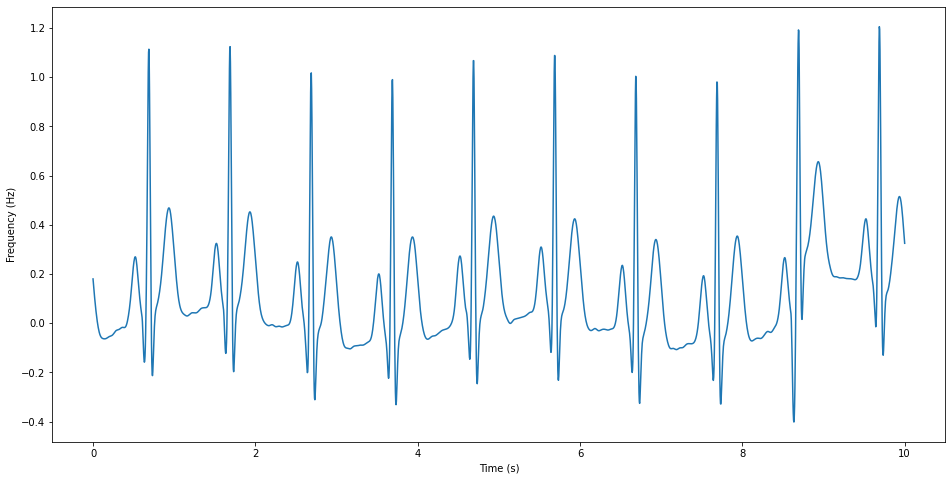

In [9]:
#%matplotlib notebook
plot_ecg_segment(zdata, params_sim['sf_ecg'])

### 2: Building a Generative Model from the Simulator

One of the ways in which BayesFlow can be used is to define a GenerativeModel, a custom class essentially created from two functions: one which generates parameters according to certain distributions (i.e. a prior), and one which generates simulated signals from those parameters (i.e. a simulator). Since our simulator is essentially the generate_ECG function above, the code below focuses primarily on parameter generation and on simulating on batches of parameters (as opposed to a single set of parameters as above).

In [10]:
## Internal utility functions for prior generation

# Retrieves the dimension of a parameter
def get_param_dim(param_name, params_sim=None):
    if param_name in ['a', 'b', 'theta']:
        return(5)
    elif param_name == 'pos_0':
        return(3)
    elif param_name == 't_span':
        return(2)
    elif param_name == 't_eval':
        return(len(params_sim['t_eval']))
    else:
        return(1)

# Separates parameters related to the ODE system itself from those related to simulation
def split_param_list(param_list, params_sim):
    for i in range(len(param_list)):
        if param_list[i] in params_sim.keys():
            param_list_ODE = param_list[:i]
            param_list_sim = param_list[i:]
            break
        else:
            i += 1
    
    if i == len(param_list):
        param_list_ODE = param_list
        param_list_sim = None
    
    return(param_list_ODE, param_list_sim)

## Prior generation

# Draws from the prior distribution of a single parameter (scalar or vector)
# The distribution in question is either 
# 1) a family of independent normal distributions centered around the default value of 
# each of the parameter's entries with a standard deviation 0.05 if entrywise is True, or
# 2) induced by muliplying the parameter with a random number with mean 0 and std 0.05 and adding
# the result to the original parameter (i.e. varying each entry by the same percentage between -5% and +5%)
# Approach 1) is the default, since approach 2) creates a degenerate prior which renders learning impossible.
# Approach 2) is only shown here to exemplify a potential caveat for priors used with BayesFlow, see below.
def generate_single_param_prior(parameter, deviation_mean = 0, deviation_std = 0.05, entrywise=True, \
                               zero_threshold=0.005, zero_replacement=0):
    
    if isinstance(parameter, int):
        parameter = float(parameter)
    
    # Differentiate between one-dimensional and multi-dimensional parameters
    # and replace values close (or identical) to zero with a small number (the variable zero_replacement)
    zero_replaced = False
    if hasattr(parameter, "__len__"):
        n = len(parameter)
        zero_indexes = np.where(np.absolute(parameter) < zero_threshold)[0]
        if len(zero_indexes) > 0:
            parameter[np.absolute(parameter) < zero_threshold] = zero_replacement
            zero_replaced = True
    else:
        n = 1
        if np.absolute(parameter) < zero_threshold:
            parameter = zero_replacement
            deviation_mean -= zero_replacement          
    
    if entrywise:
        variation_coefficient = np.random.normal(deviation_mean, deviation_std, n)
    else:
        variation_coefficient = np.random.normal(deviation_mean, deviation_std)
    
    output_p = parameter + parameter*variation_coefficient
    
    if zero_replaced:
        output_p[zero_indexes] -= zero_replacement
    
    if np.ndim(output_p) == 0:
        output_p = np.array([output_p])
    
    return(output_p)

# Batched version of the above function
def generate_single_param_prior_batch(parameter, batch_size, deviation_mean = 0, deviation_std = 0.05, \
                                     entrywise=True, zero_threshold=0.005, zero_replacement=0.05):
    
    if isinstance(parameter, int):
        parameter = float(parameter)
    
    zero_replaced = False
    if hasattr(parameter, "__len__"):
        n = len(parameter)
        zero_indices = np.where(np.absolute(parameter) < zero_threshold)[0]
        if len(zero_indices) > 0:
            parameter[np.absolute(parameter) < zero_threshold] = zero_replacement
            zero_replaced = True
    else:
        n = 1
        if np.absolute(parameter) < zero_threshold:
            parameter = zero_replacement
            deviation_mean -= zero_replacement         
    
    output_p = np.tile(parameter, (batch_size,1))
    
    if entrywise:
        variation_coefficients = np.random.normal(deviation_mean, deviation_std, (batch_size, n))
        output_p = output_p + output_p*variation_coefficients
    else:
        variation_coefficients = np.random.normal(deviation_mean, deviation_std, batch_size)
        output_p = output_p + output_p*variation_coefficients[:, np.newaxis]
     
    if zero_replaced:
        M = len(zero_indices)
        for i in range(M):
            ind_tuple = (np.arange(batch_size), zero_indices[i]*np.ones(batch_size, dtype=int))
            output_p[ind_tuple] -= zero_replacement

    
    # Ensure that the output is an array of arrays (as opposed to an array of floats)
    if np.ndim(output_p[0]) == 0:
        output_p = np.asarray([[output_p[i]] for i in range(len(output_p))])
    
    return(output_p)

# Generates a concatenation of prior draws for all parameters being varied
def generate_ecg_parameter_prior(params_ODE, params_sim, deviation_mean=0, deviation_std=0.05,\
                                 ODE_params_to_vary=['b','theta','f_2'], sim_params_to_vary=[], \
                                 entrywise=True, zero_replacement=0.05):
    
    output_list = []
    variable_list = []
    
    for p in ODE_params_to_vary:
        original_p = copy.deepcopy(params_ODE[p])
        output_p = generate_single_param_prior(original_p, deviation_mean, deviation_std, \
                                               entrywise=entrywise, zero_replacement=zero_replacement)
        output_list += [output_p]
    
    for p in sim_params_to_vary:
        original_p = copy.deepcopy(params_sim[p])
        output_p = generate_single_param_prior(original_p, deviation_mean, deviation_std, entrywise=entrywise)
        output_list += [output_p]
    
    output_array=np.concatenate(output_list)
    
    return(output_array)

# Batched version of the above function
def generate_ecg_parameter_prior_batch(batch_size, params_ODE, params_sim=None, deviation_mean=0, \
                                       deviation_std=0.05, ODE_params_to_vary=['b','theta','f_2'], \
                                       sim_params_to_vary=[], entrywise=True, zero_replacement =0.05):
    
    output_list = []
    variable_list = []
    
    for p in ODE_params_to_vary:
        original_p = copy.deepcopy(params_ODE[p])
        output_p = generate_single_param_prior_batch(original_p, batch_size, deviation_mean, deviation_std, \
                                                    entrywise=entrywise, zero_replacement=zero_replacement)
        output_list += [output_p]
        #variable_list += [p]
    
    for p in sim_params_to_vary:
        original_p = copy.deepcopy(params_sim[p])
        output_p = generate_single_param_prior_batch(original_p, batch_size, deviation_mean, deviation_std, \
                                                    entrywise = entrywise, zero_replacement=zero_replacement)
        output_list += [output_p]
        #variable_list += [p]
    
    #print("Prior generated for {}".format(variable_list))
    
    return(np.concatenate(output_list, axis=1))

# Simulates data from a single prior sample
def simulate_one(prior_sample, params_ODE, params_sim, param_list =['b', 'theta', 'f_2']): 
    
    param_list_ODE, param_list_sim = split_param_list(param_list, params_sim)
    
    output_ODE = {}
    current_index = 0
    for p in param_list_ODE:
        next_index = current_index + get_param_dim(p, params_sim)
        output_ODE[p] = prior_sample[current_index:next_index]
        current_index = next_index

    
    if param_list_sim is not None:
        sim_param_change = True
        output_sim = {}
        for q in param_list_sim:
            d = get_param_dim(q, params_sim)
            next_index = current_index + d
            if d > 1:
                output_sim[q] = prior_sample[current_index:next_index]
            else:
                output_sim[q] = prior_sample[current_index]
            current_index = next_index
    
    current_params_ODE = copy.deepcopy(params_ODE)
    current_params_sim = copy.deepcopy(params_sim)

    
    for p in param_list_ODE:
        current_params_ODE[p] = output_ODE[p]
        if sim_param_change:
            for q in param_list_sim:
                current_params_sim[q] = output_sim[q]
    _, _, z = generate_ECG(current_params_ODE, current_params_sim, baseline_wander=True)
    
    return(z)

# Batched version of the above function
def simulate_batch(prior_sample, params_ODE, params_sim, param_list =['b', 'theta', 'f_2']): 
    
    param_list_ODE, param_list_sim = split_param_list(param_list, params_sim)
    
    output_ODE = {}
    current_index = 0
    for p in param_list_ODE:
        next_index = current_index + get_param_dim(p, params_sim)
        output_ODE[p] = prior_sample[:,current_index:next_index]
        current_index = next_index
    
    if param_list_sim is not None:
        sim_param_change = True
        output_sim = {}
        for q in param_list_sim:
            d = get_param_dim(q, params_sim)
            next_index = current_index + d
            if d > 1:
                output_sim[q] = prior_sample[:,current_index:next_index]
            else:
                output_sim[q] = prior_sample[:,current_index]
            current_index = next_index
    
    current_params_ODE = copy.deepcopy(params_ODE)
    current_params_sim = copy.deepcopy(params_sim)
    
    if len(param_list_ODE) > 0:
        n = output_ODE[param_list_ODE[0]].shape[0]
    else:
        n = output_sim[param_list_sim[0]].shape[0]
    
    batch = []
    
    for i in range(n):
        for p in param_list_ODE:
            current_params_ODE[p] = output_ODE[p][i]
        if sim_param_change:
            for q in param_list_sim:
                current_params_sim[q] = output_sim[q][i]
        _, _, z = generate_ECG(current_params_ODE, current_params_sim, baseline_wander=True)
        batch += [z]
    
    batch = np.array(batch)
    
    return(batch)

The above implementation can in principle be used to define and draw from priors for any of the model parameters initialized with initialize_model_parameters(). However, not all choices make sense.

Certain parameters depend on each other (e.g. specifying duration and the internal sampling frequency sf_int specify the total number of time steps Nt), and certain others can be assumed to be constant for the time frames under consideration (e.g. $f_2$). 

The most obvious candidates for parameters to predict, then, are those characterizing the IVP, i.e. $a, b$ and $\theta$, along with the simulation parameter with the greatest impact on the signal, the mean heartrate. Counted entrywise, this amounts to 16 parameters whose distribution we want BayesFlow to learn:

In [11]:
# Select parameters to vary, based on which dictionary they are contained in (params_ODE or params_sim)
ODE_params_to_vary = ['a', 'b', 'theta']
#ODE_params_to_vary = ['f_2']
#ODE_params_to_vary = ['a']
sim_params_to_vary = ['heartrate_mean']

# Create a combined list of parameters for later use
param_list = np.concatenate([ODE_params_to_vary, sim_params_to_vary])

# Generate names for each entry of the parameters
param_names = []
for param in param_list:
    p_dim = get_param_dim(param)
    if p_dim > 1:
        param_names += [param+'_'+str(i+1) for i in range(p_dim)]
    else:
        param_names += [param]

print(param_names)

# Determine the number of parameters (counting each n-dimensional parameter as n parameters)
n_params = len(param_names)
print(f"\nNumber of parameters: {n_params}")

['a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'heartrate_mean']

Number of parameters: 16


Having chosen which parameters to vary, we prepare our above prior and simulator functions for use in BayesFlow by passing them to the appropriate wrappers, Prior and Simulator respectively. Both accept functions producing individual datasets (i.e. one value for each of our 16 parameters along with one ECG signal) or batches thereof (e.g. 64 sets of 16 parameters, 64 signals). 

This can be relevant for simulations which are computationally expensive, since parallelization may be possible. We do not explore this question here, however - providing unbatched versions in the next cell would produce the same result as the current, batched solution.

In [12]:
# Define the prior
prior_ecg = Prior(batch_prior_fun = partial(generate_ecg_parameter_prior_batch, params_ODE=params_ODE, \
                                            params_sim=params_sim, ODE_params_to_vary=ODE_params_to_vary, \
                                            sim_params_to_vary=sim_params_to_vary),\
                  param_names=param_names
)


# WARNING: Uncomment only to see pathological prior:
# prior_ecg = Prior(batch_prior_fun=partial(generate_ecg_parameter_prior_batch, params_ODE=params_ODE, \
#                                           params_sim=params_sim, ODE_params_to_vary=ODE_params_to_vary,
#                                           sim_params_to_vary=sim_params_to_vary, \
#                                           entrywise=False, zero_replacement=0),\
#           param_names=param_names
# )


# Define the simulator
simulator_ecg = Simulator(
    batch_simulator_fun=partial(simulate_batch, params_ODE=params_ODE, params_sim=params_sim,\
                      param_list=param_list)
)


# Unbatched versions, should you wish to try them out:
# prior_ecg = Prior(prior_fun=partial(generate_ecg_parameter_prior, params_ODE=params_ODE, params_sim=params_sim, \
#                             ODE_params_to_vary=ODE_params_to_vary, \
#                             sim_params_to_vary=sim_params_to_vary, entrywise=False),\
#           param_names=param_names
# )
# simulator = Simulator(
#     simulator_fun=partial(simulate_one, params_ODE=params_ODE, params_sim=params_sim,\
#                           param_list=['b', 'heartrate_mean'])
# )

We are now ready to combine our prior and simulator into a GenerativeModel. Instantiating this class also runs an initial test to ensure that the inputs we've made so far have been consistent:

In [13]:
model_ecg = GenerativeModel(prior_ecg, simulator_ecg, name='basic_ecg_simulator')

INFO:root:Performing 2 pilot runs with the basic_ecg_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 16)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2500)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Before training BayesFlow, it makes sense to inspect our prior by estimating joint density functions for all possible pairs of parameters. In the figure below, we can see that all is well.

Pathological priors which could be caught at this stage might, for instance, involve perfectly correlated pairs of parameters (i.e. with a correlation of 1 or -1), which would lead to prior distributions looking like straight diagonal lines in the plots below. Constant parameters would be equally problematic, and they would manifest as straight vertical lines in the plots below. Either occurrence (perfectly correlated / constant) renders kernel density estimation impossible, and since this process underlies the graphs in the lower triangle of the plot, this leads to a warning as a further clue to the user that something is wrong with the prior.

If you wish to see these situations, feel free to uncomment the appropriate lines in the cell defining prior_ecg above. Make sure to restore the normal configuration afterwards, however, since these pathologies render training impossible - in both cases, you would be asking BayesFlow to map a one-dimensional object (a straight line) onto a two-dimensional one (a 2D distribution), which it cannot do.

In [14]:
#As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
#f = prior_ecg.plot_prior2d()

### 3. Setting up BayesFlow's Neural Architecture

The next step is to define a summary network. There are two primary considerations here:
1) What kind of architecture can capture as many important features of the simulated data as possible?
2) How small should the resulting summarized representation of the simulated data be?

Where the first of these questions is concerned, domain knowledge can often come in handy: it makes sense to choose a neural architecture which has been used successfully in a related task on similar data.

For instance, below, a variant of the convolutional neural network (CNN) used by Wu et al. (2021) ( https://www.frontiersin.org/articles/10.3389/fncom.2020.564015/full ) to classify ECG signals into classes corresponding to diagnoses is implemented.

Regarding the second question, in the absence of domain knowledge pointing to a specific number of latent parameters, four times the number of parameters is a sensible starting point; this is what was adopted below, i.e. n_summary = $4\cdot16 = 64$.

In [15]:
class NN_ecg(tf.keras.Model):
    def __init__(self, n_summary, sampling_frequency):
        super(NN_ecg, self).__init__()
        
        self.conv =  tf.keras.Sequential([
            tf.keras.layers.Conv1D(sampling_frequency, kernel_size=int(sampling_frequency/28), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/2-1), kernel_size=int(sampling_frequency/28+2), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/4-1), kernel_size=int(sampling_frequency/28+4), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Conv1D(int(sampling_frequency/8-1), kernel_size=int(sampling_frequency/28+6), strides=1, 
                                   padding='causal', activation='relu'),
            tf.keras.layers.AveragePooling1D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(n_summary) 
        ])
#        self.full = tf.keras.layers.Dense(n_summary)
#        self.lstm = tf.keras.layers.LSTM(n_summary)
#         self.conv = tf.keras.layers.Conv1D(n_summary, kernel_size=sampling_frequency, strides=1,
#                                    padding='causal', activation='relu', kernel_initializer='glorot_uniform')
#         self.lstm = tf.keras.Sequential([
#             tf.keras.layers.LSTM(n_summary, return_sequences=True),
#             tf.keras.layers.LSTM(n_summary, return_sequences=True),
#             tf.keras.layers.LSTM(n_summary)])

    def call(self, x, **args):
        """x is a 3D tensor of shape (batch_size, n_time_steps, n_time_series)"""

        out = self.conv(x)
        #out = self.full(out)
        #out = self.lstm(x)
        return out

We specify the parameters of our summary network to match the desired latent summary dimensions (n_summary = 64) and, in our specific case, the ECG sampling frequency (sf_ecg = 250). 

The invertible neural network (INN) we will be combining with this summary network can be generated by BayesFlow with as little as two inputs - a number of parameters n_params and a number of desired coupling layers n_coupling_layers. This, too, is done below. 

In [16]:
summary_net_ecg = NN_ecg(n_summary=n_summary, sampling_frequency=params_sim['sf_ecg'])
inference_net_ecg = InvertibleNetwork({
    'n_params': n_params, 
    'n_coupling_layers': depth_INN, 
})

2022-09-22 16:34:18.428903: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-22 16:34:18.429752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-22 16:34:20.419529: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-22 16:34:20.419563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rene-LENOVO-Y520-15IKBN): /proc/driver/nvidia/version does not exist
2022-09-22 16:34:20.421204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

It may make sense to test the summary network on its own to ensure that, if nothing else, the various layers are compatible with one another. If they are, the following cell will produce an output; otherwise, it will raise an error.

In [17]:
# The data must go through a configurator in order to be compatible with the summary network
# A more detailed explanation is given below
def simulator_configurator(simdata):
    simdata = np.expand_dims(simdata, axis=2)
    flt32data = simdata.astype(np.float32)
    return(flt32data)

mini_prior = generate_ecg_parameter_prior_batch(10, params_ODE, params_sim, \
                                        ODE_params_to_vary = ODE_params_to_vary, \
                                        sim_params_to_vary= sim_params_to_vary)
mini_batch = simulate_batch(mini_prior, params_ODE, params_sim, param_list = param_list)

mini_conf_batch = simulator_configurator(mini_batch)
summary_net_ecg(mini_conf_batch)

<tf.Tensor: shape=(10, 64), dtype=float32, numpy=
array([[ 8.75072367e-03,  3.95302754e-03,  3.94459628e-03,
        -3.05045815e-03,  1.79221965e-02,  7.08554732e-03,
         1.01567227e-02,  1.36339944e-02,  1.51880016e-03,
        -1.17502986e-02,  2.14139931e-04, -5.85043617e-03,
        -3.71529628e-03,  8.56425334e-03,  3.76431411e-03,
        -1.19700786e-02, -4.30003088e-03, -6.62911218e-04,
        -2.79694656e-03,  9.67588089e-03,  7.65327830e-03,
         1.49606261e-02,  1.31358225e-02, -5.55375032e-03,
         3.04132653e-03,  4.84221242e-03, -9.54727270e-03,
        -2.84037320e-03,  6.02857349e-03, -1.41799878e-02,
        -2.11288854e-02,  4.63192072e-03, -5.95893711e-04,
        -4.80058882e-03,  1.61185972e-02,  6.93520857e-03,
        -1.58029292e-02,  8.07955489e-03,  1.33745177e-02,
        -3.10257310e-03, -2.91149900e-03,  4.55524214e-03,
         5.37774432e-03, -2.78485077e-03, -4.44819732e-03,
        -3.96633428e-03,  1.20319072e-02,  4.26617218e-03,
      

Next, we combine our summary network and INN into a single amortizer network using BayesFlow's AmortizedPosterior class:

In [18]:
amortizer_ecg = AmortizedPosterior(inference_net_ecg, summary_net_ecg, name='ecg_amortizer')

The final step before training is to configure prior draws and simulation data for training.

Up to three steps are typically required:
1) Reshaping the simulation data. CNNs require inputs of the shape (batch size, signal length, number of channels), i.e. (batch size, signal length, 1) in our case.
2) Casting to single-precision float. If a GPU is available, it will speed up training immensely, and GPUs typically have much more processing power for single-precision float numbers (float32).
3) Normalizing. Both passing through and updating a neural network repeatedly involves matrix-vector multiplication, and entries of vastly different size make this operation notoriously ill-conditioned. For the simulation data, this can lead to vanishing or exploding gradients during training, and for the parameters, it can cause much greater uncertainty in the predicted posterior distributions.

The first two steps are carried out below largely as-is.

Normalization is a little less obvious. Since our model already includes a normalizing step for the simulated data (constraining the simulated ECG signal to the range between -0.4 and +1.2 Hz), we do not need to add another one here. We do, however, need to normalize our priors so that they have mean 0 and variance 1. To do so, we must first compute their unnormalized means and stds:

In [19]:
prior_means, prior_stds = prior_ecg.estimate_means_and_stds()

In [20]:
def configurator_ecg(forward_dict):
    # Prepare placeholder dict
    out_dict = {}
    
    # Reshape data to (batch size, signal length, 1) and cast data to float32
    # GPUs are optimized for float32 computations, and convolutional NN require
    # the number of channels as a third dimension - this is 1 for the ECG signal
    simdata = forward_dict['sim_data']
    simdata = np.expand_dims(simdata, axis=2)
    flt32data = simdata.astype(np.float32)
    
    # Cast parameters to float32
    ### (Extract prior draws and z-standardize with previously computed means)
    params = forward_dict['prior_draws'].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Add to keys
    out_dict['summary_conditions'] = flt32data#[idx_keep]
    out_dict['parameters'] = params#[idx_keep]
    
    return out_dict  

### 4. Training and Evaluation

With our AmortizedPosterior, GenerativeModel and Configurator, we are now ready to create a trainer instance. Doing so before starting the actual training results in a small test run to ensure that all components are consistent with one another:

In [21]:
trainer_ecg = Trainer(amortizer=amortizer_ecg, generative_model=model_ecg, configurator=configurator_ecg,
                     checkpoint_path = checkpoint_path)

INFO:root:Loaded loss history from /home/rene/Bf_ecg/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Sep22/history_16.pkl
INFO:root:Loaded simulation memory from /home/rene/Bf_ecg/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Sep22/memory_16.pkl
INFO:root:Networks loaded from /home/rene/Bf_ecg/BayesFlow/docs/source/tutorial_notebooks/checkpoints_Sep22/ckpt-16
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Instantiating the Trainer above caused the BayesFlow model to actually be built. We are now in a position to look at some statistics about our architecture:

In [22]:
amortizer_ecg.summary()

Model: "ecg_amortizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
invertible_network (Invertib multiple                  299776    
_________________________________________________________________
nn_ecg (NN_ecg)              multiple                  726517    
Total params: 1,026,293
Trainable params: 1,026,037
Non-trainable params: 256
_________________________________________________________________


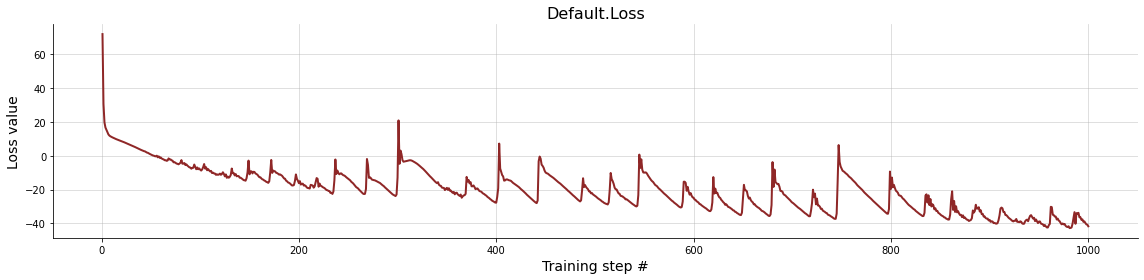

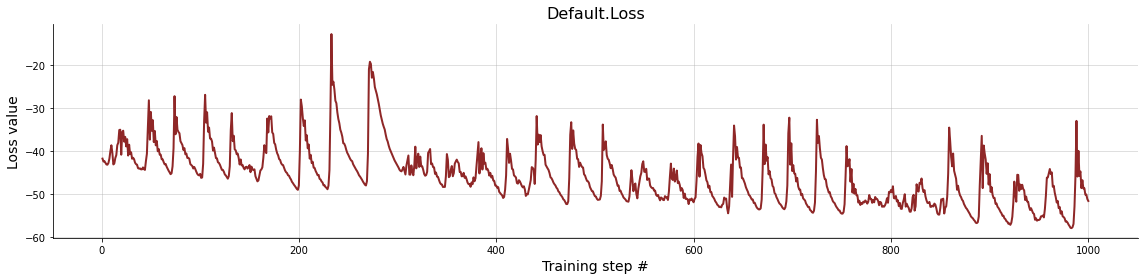

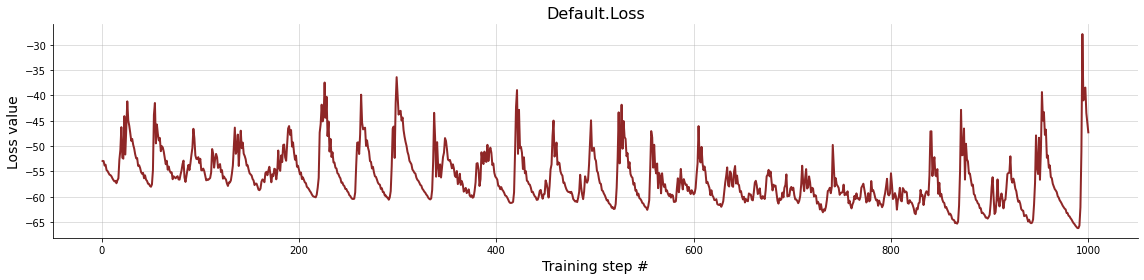

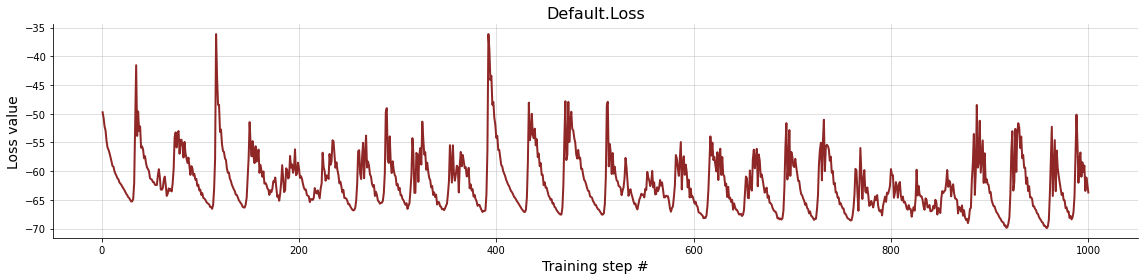

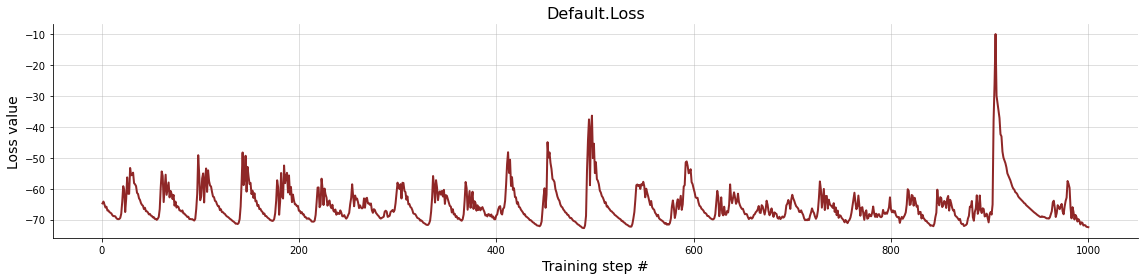

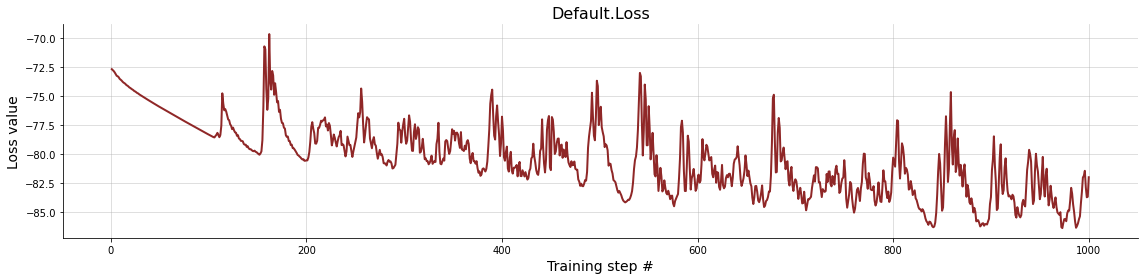

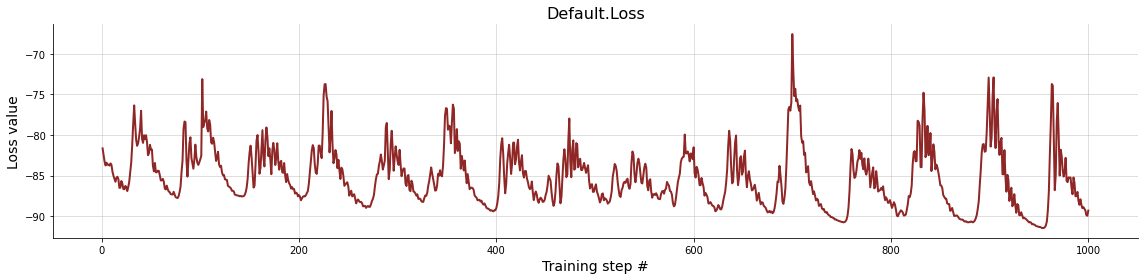

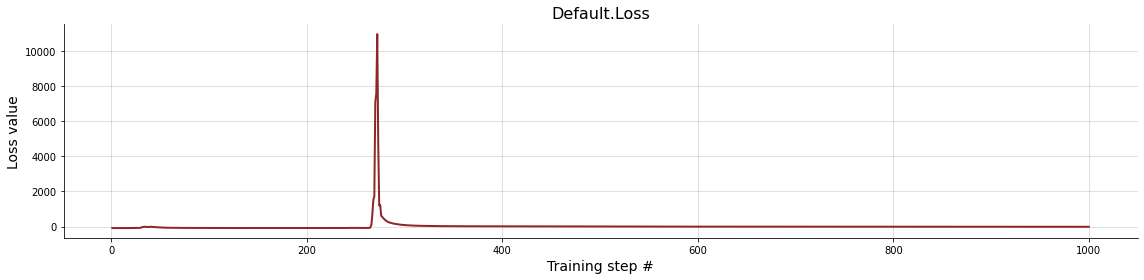

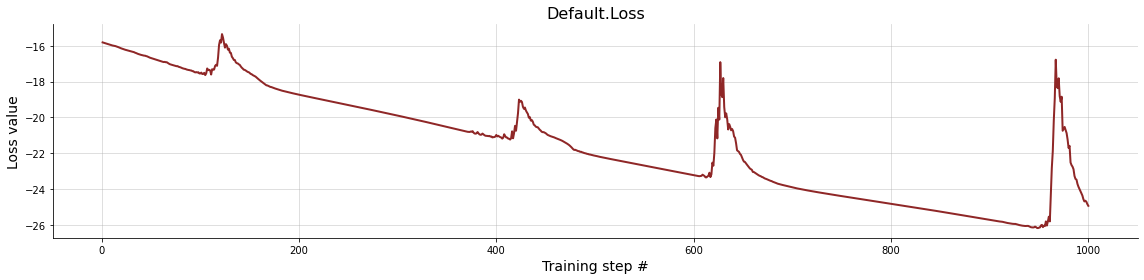

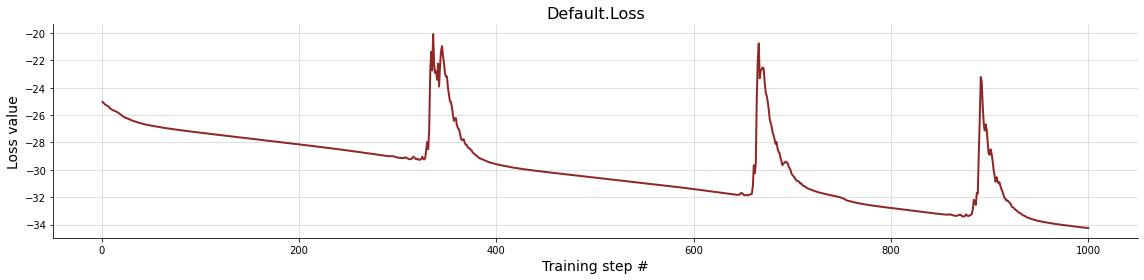

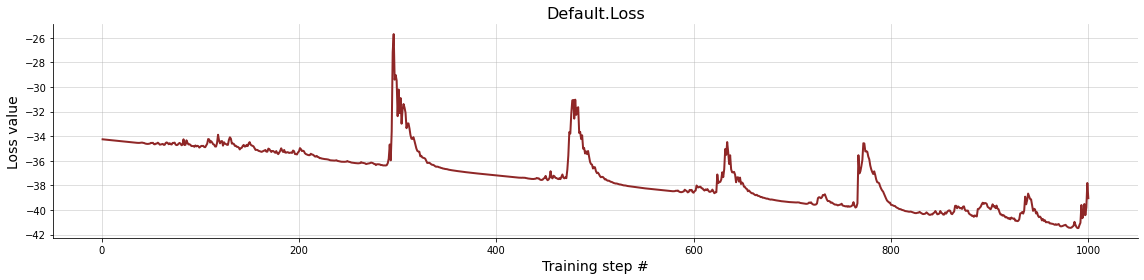

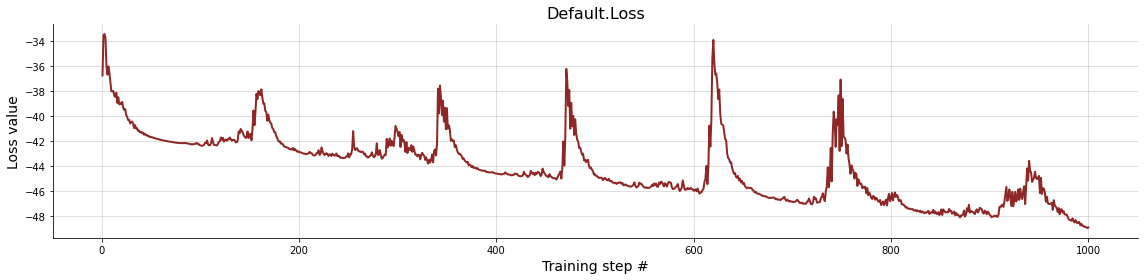

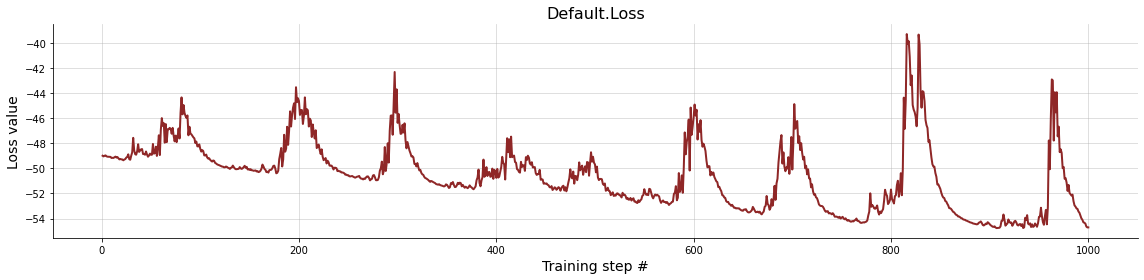

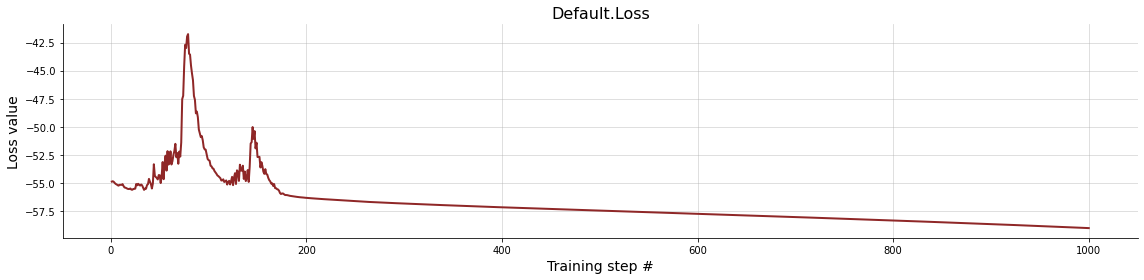

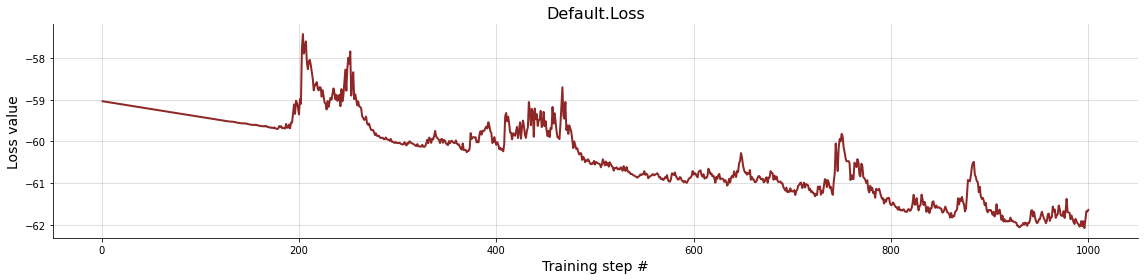

In [23]:
losses = trainer_ecg.loss_history.get_plottable()
stepsize= 1000
for i in range(int(15000/stepsize)):
    fig = diag.plot_losses(losses[i*stepsize:(i+1)*stepsize])

# LR adjustments triggered at 4979 its, 7349 its, 13169 its and 15410 its (=stop)

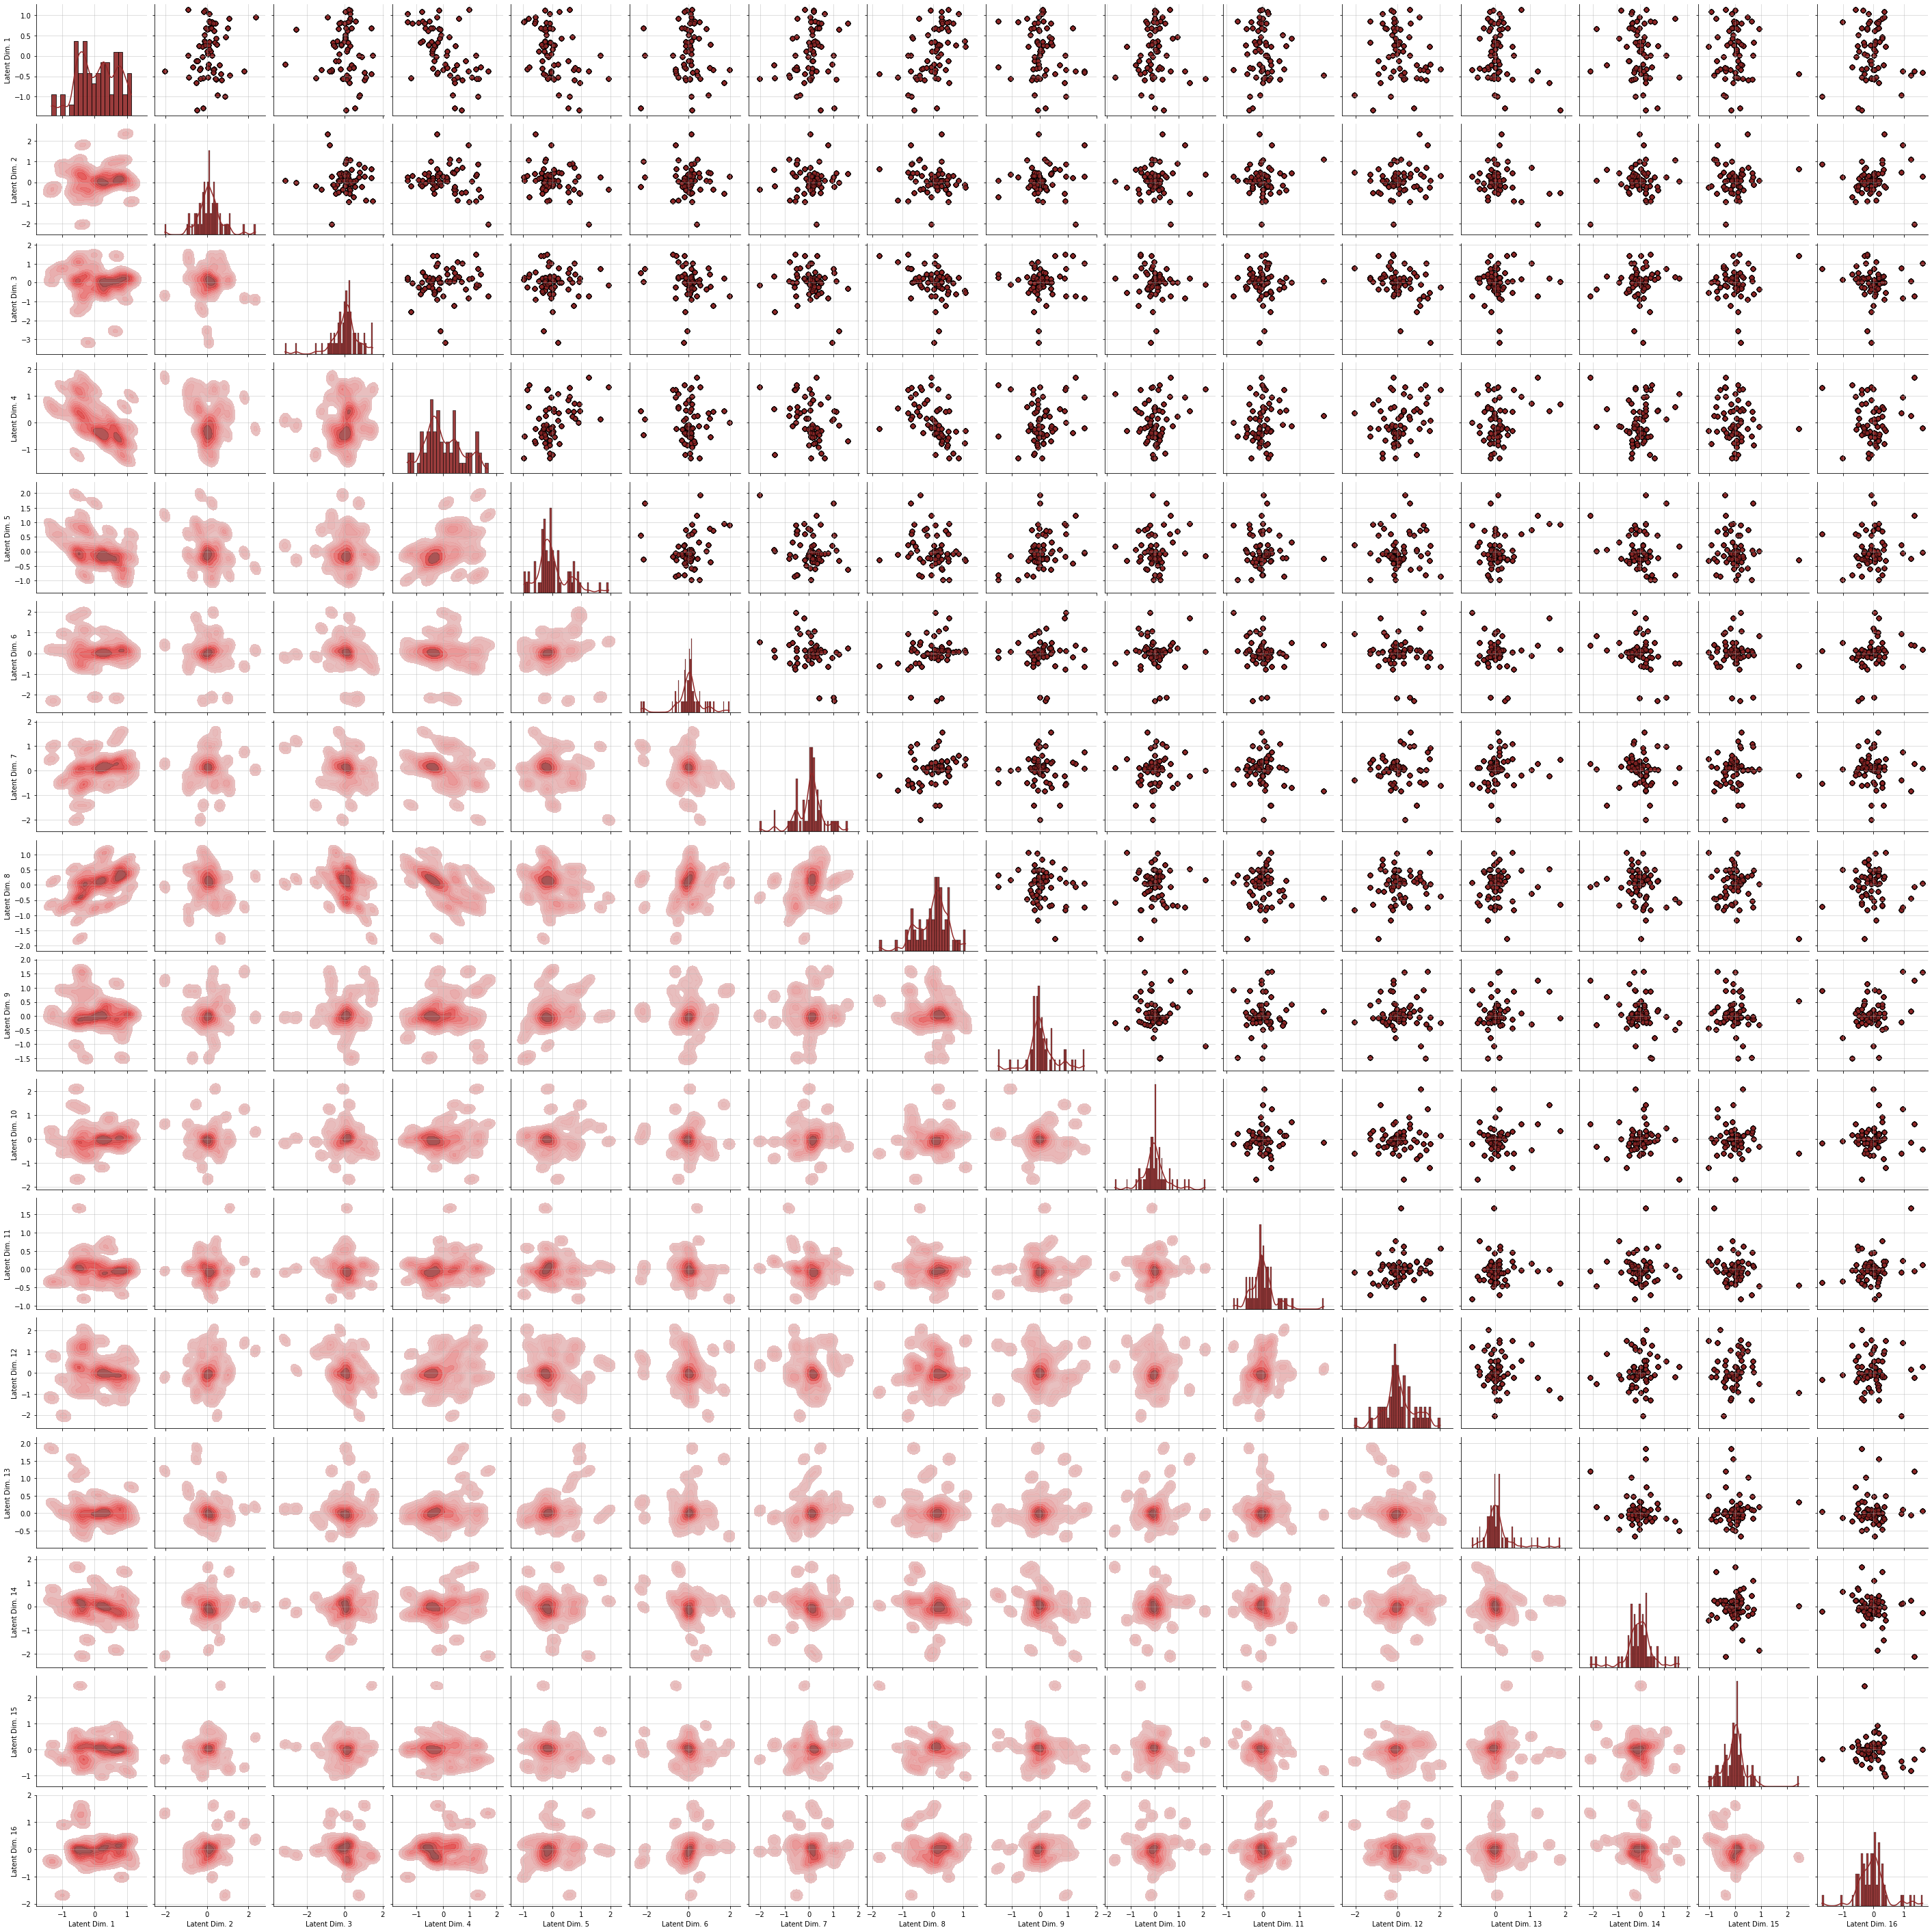

In [24]:
fig_2 = trainer_ecg.diagnose_latent2d()

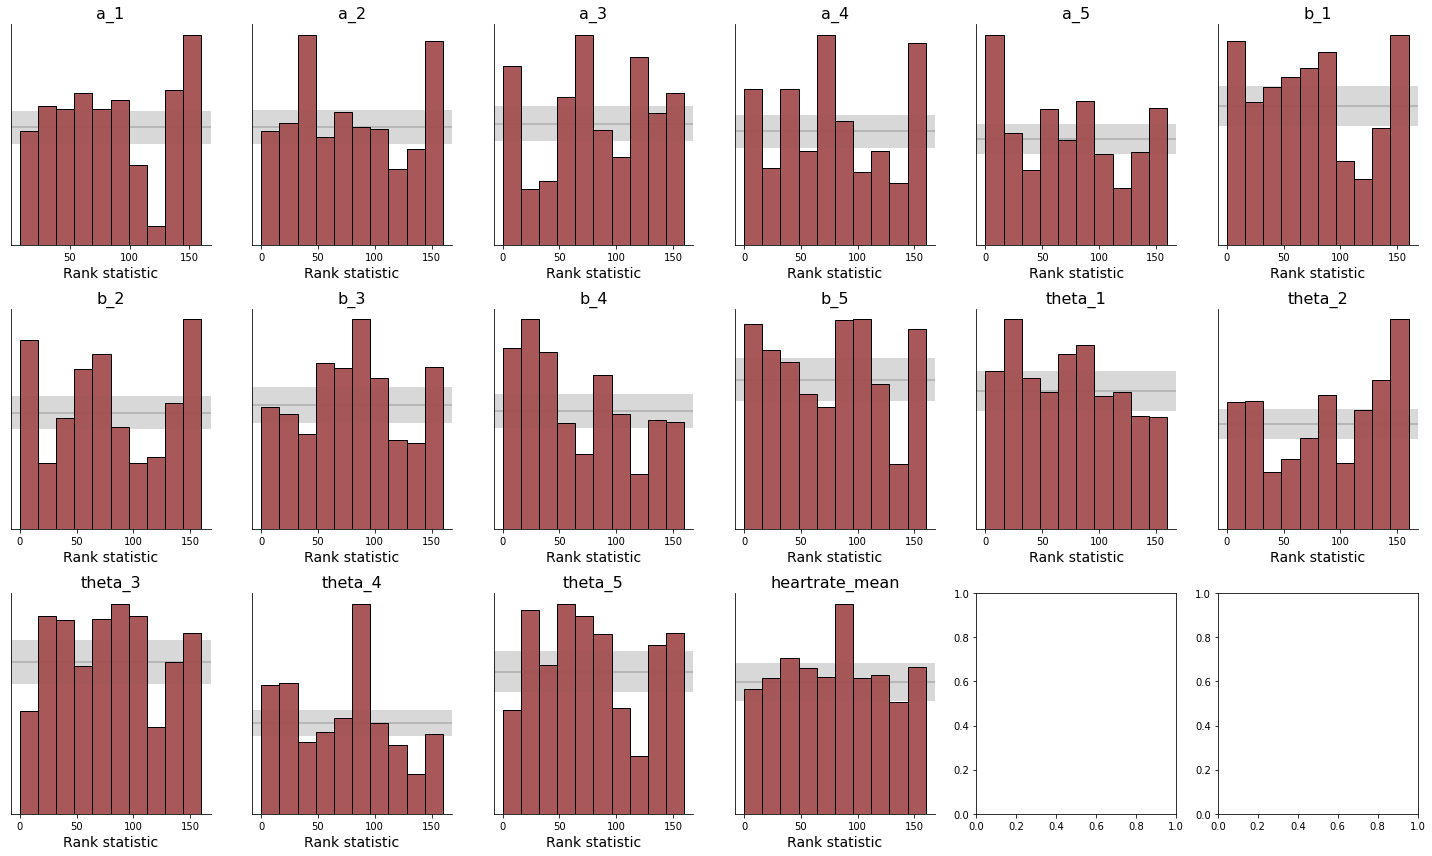

In [25]:
fig_3 = trainer_ecg.diagnose_sbc_histograms()

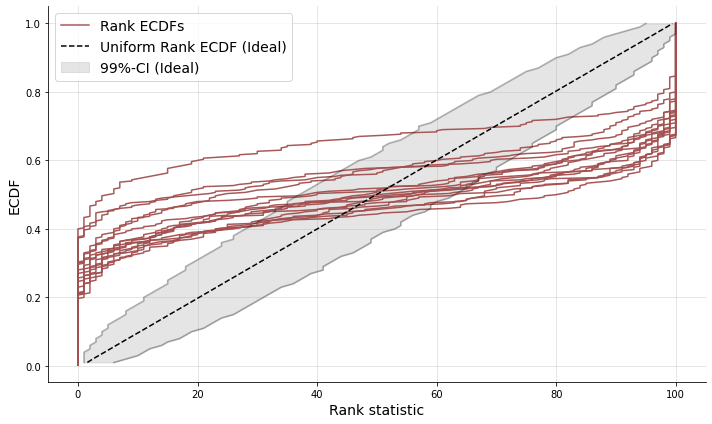

In [26]:
valid_sim_data_raw = model_ecg(batch_size=300)
#valid_sim_data_raw = model_ecg(batch_size=1000)
valid_sim_data = trainer_ecg.configurator(valid_sim_data_raw)
posterior_samples = amortizer_ecg.sample(valid_sim_data, n_samples=100)
#posterior_samples = amortizer_ecg.sample(valid_sim_data, n_samples=300)
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data['parameters'])

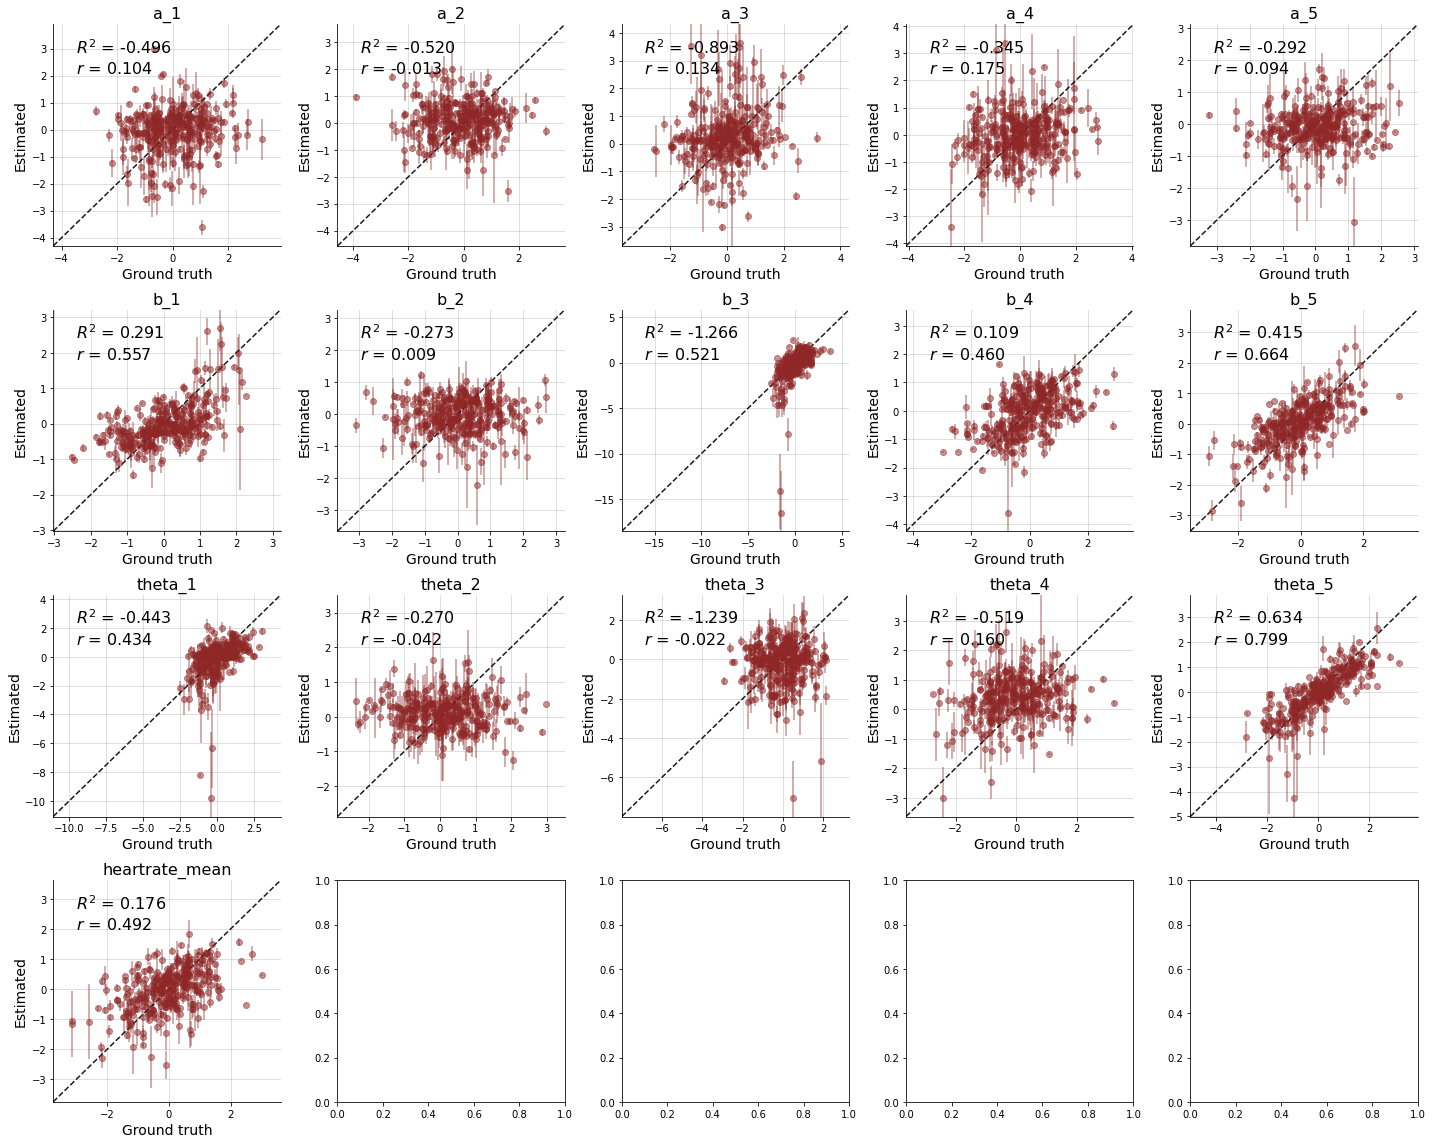

In [27]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data['parameters'], param_names=prior_ecg.param_names, n_col=5)

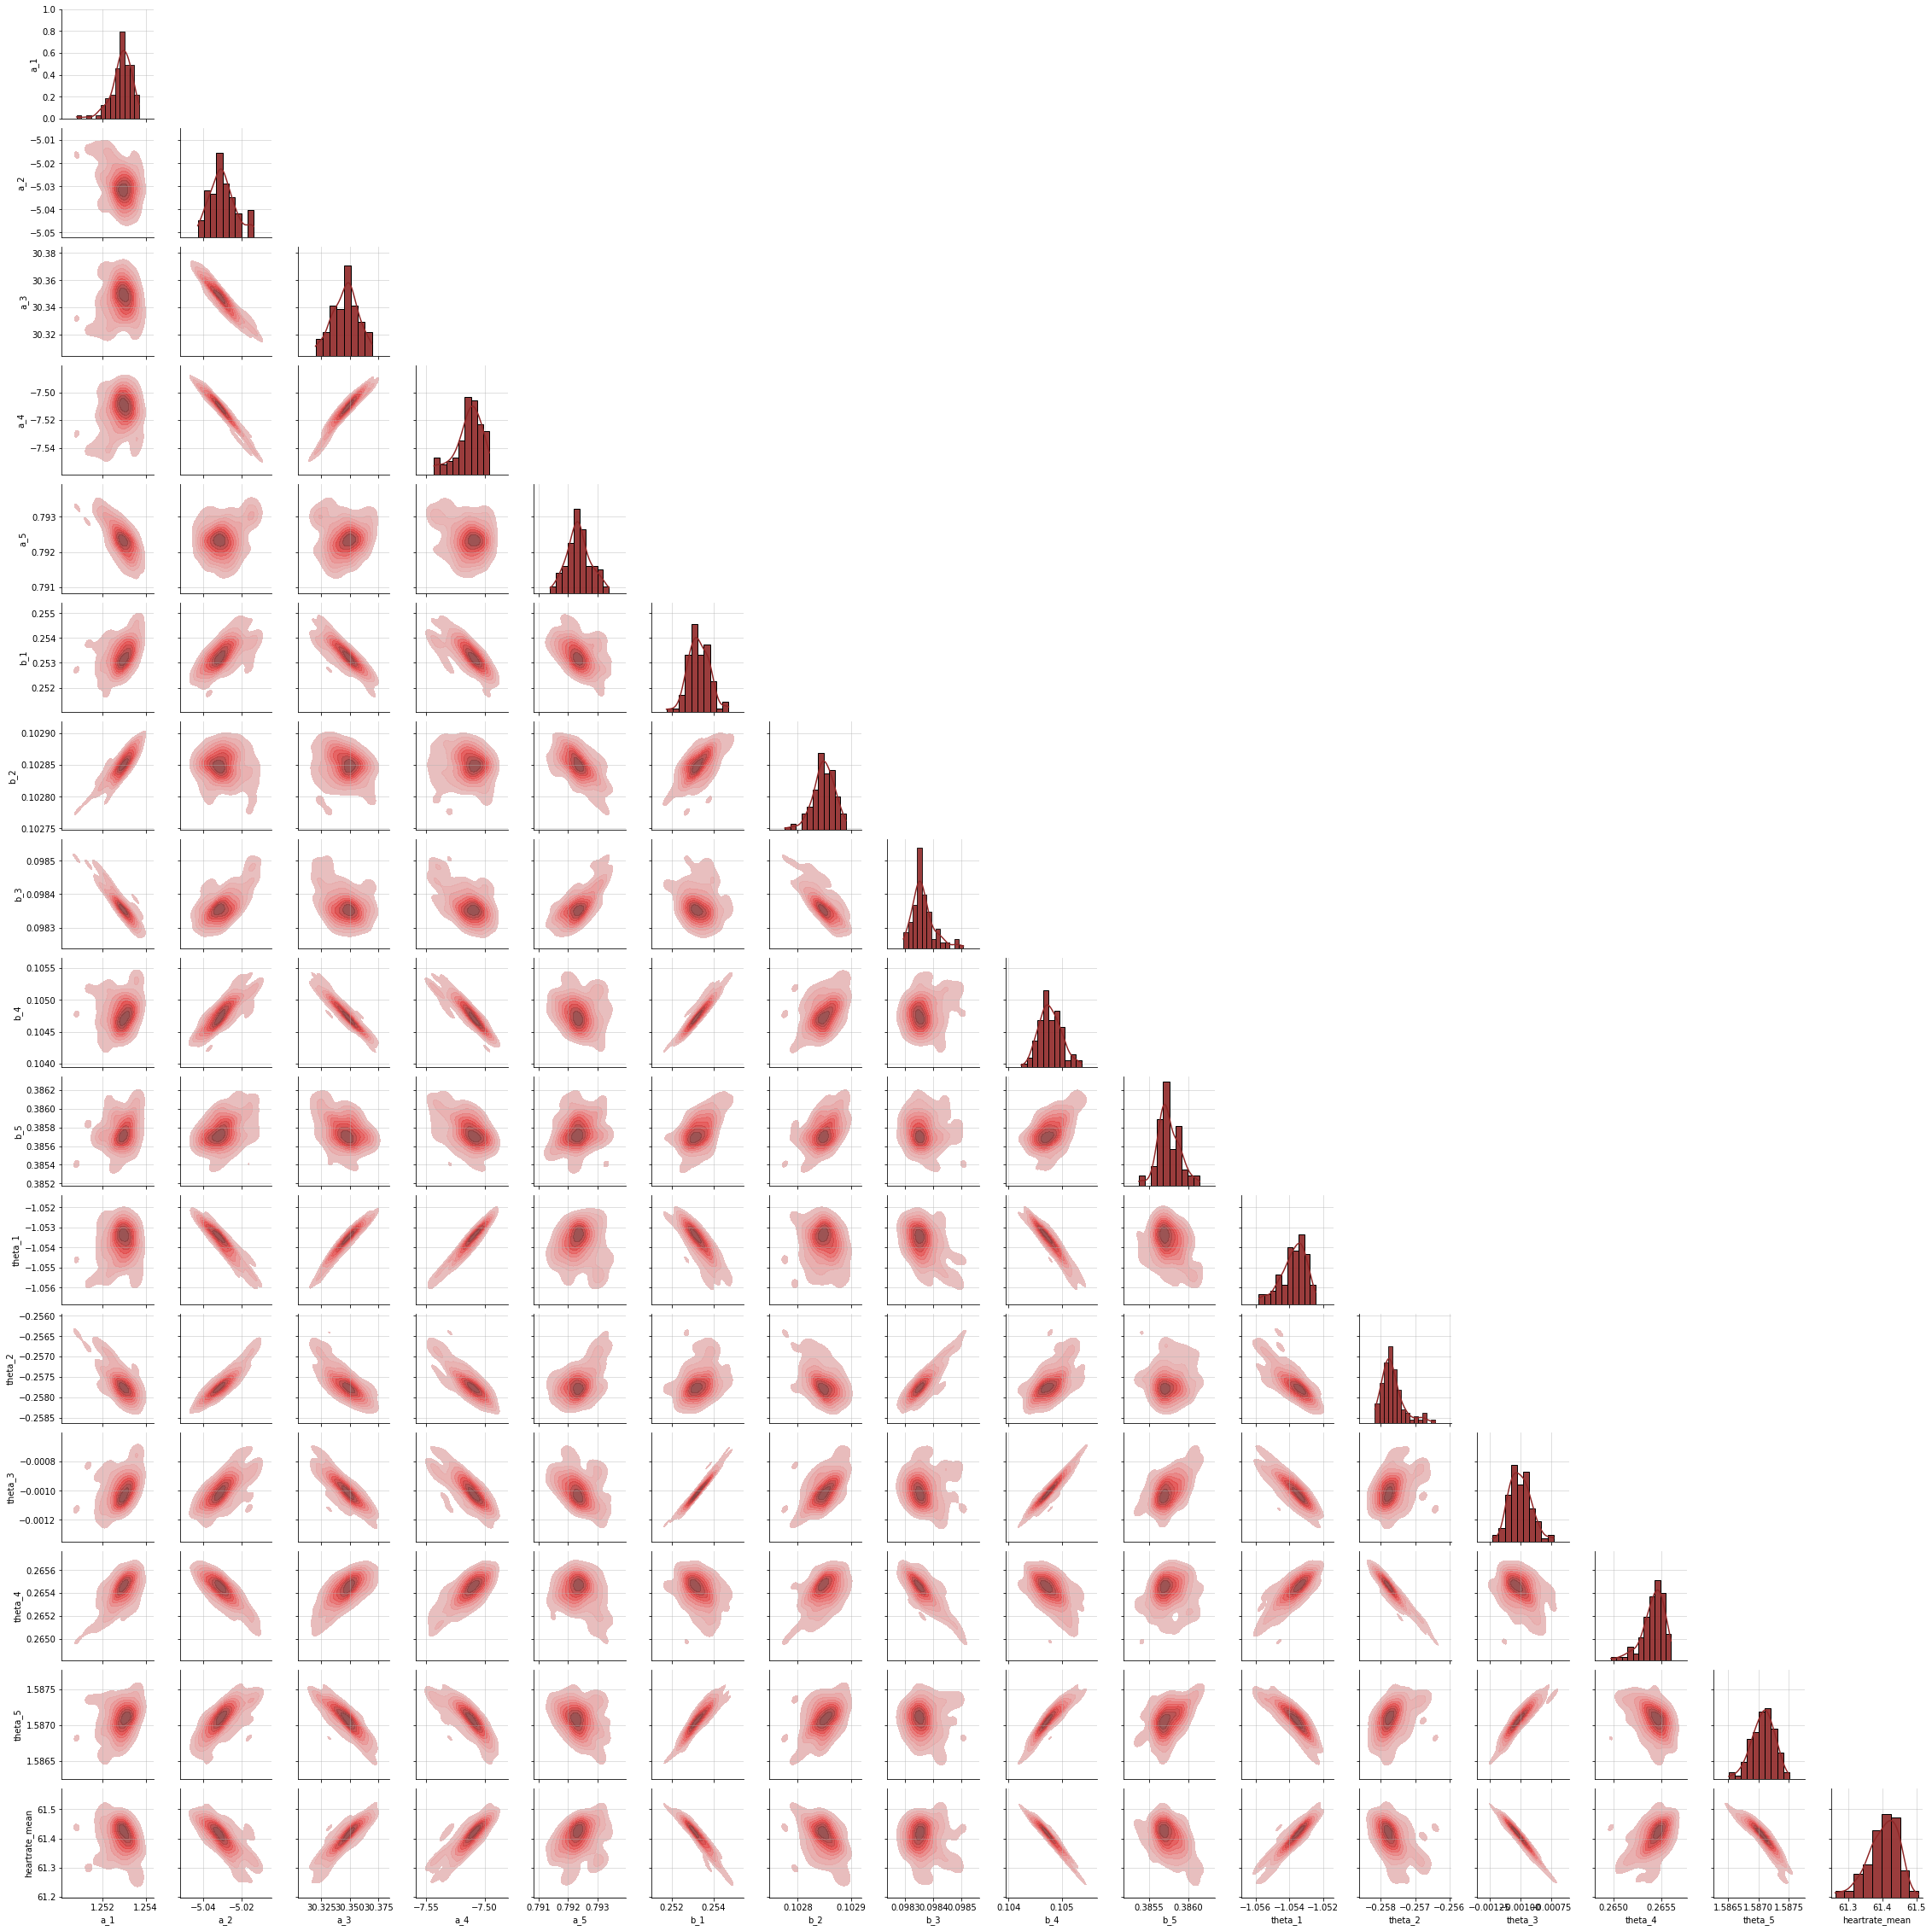

In [28]:
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], param_names=prior_ecg.param_names)

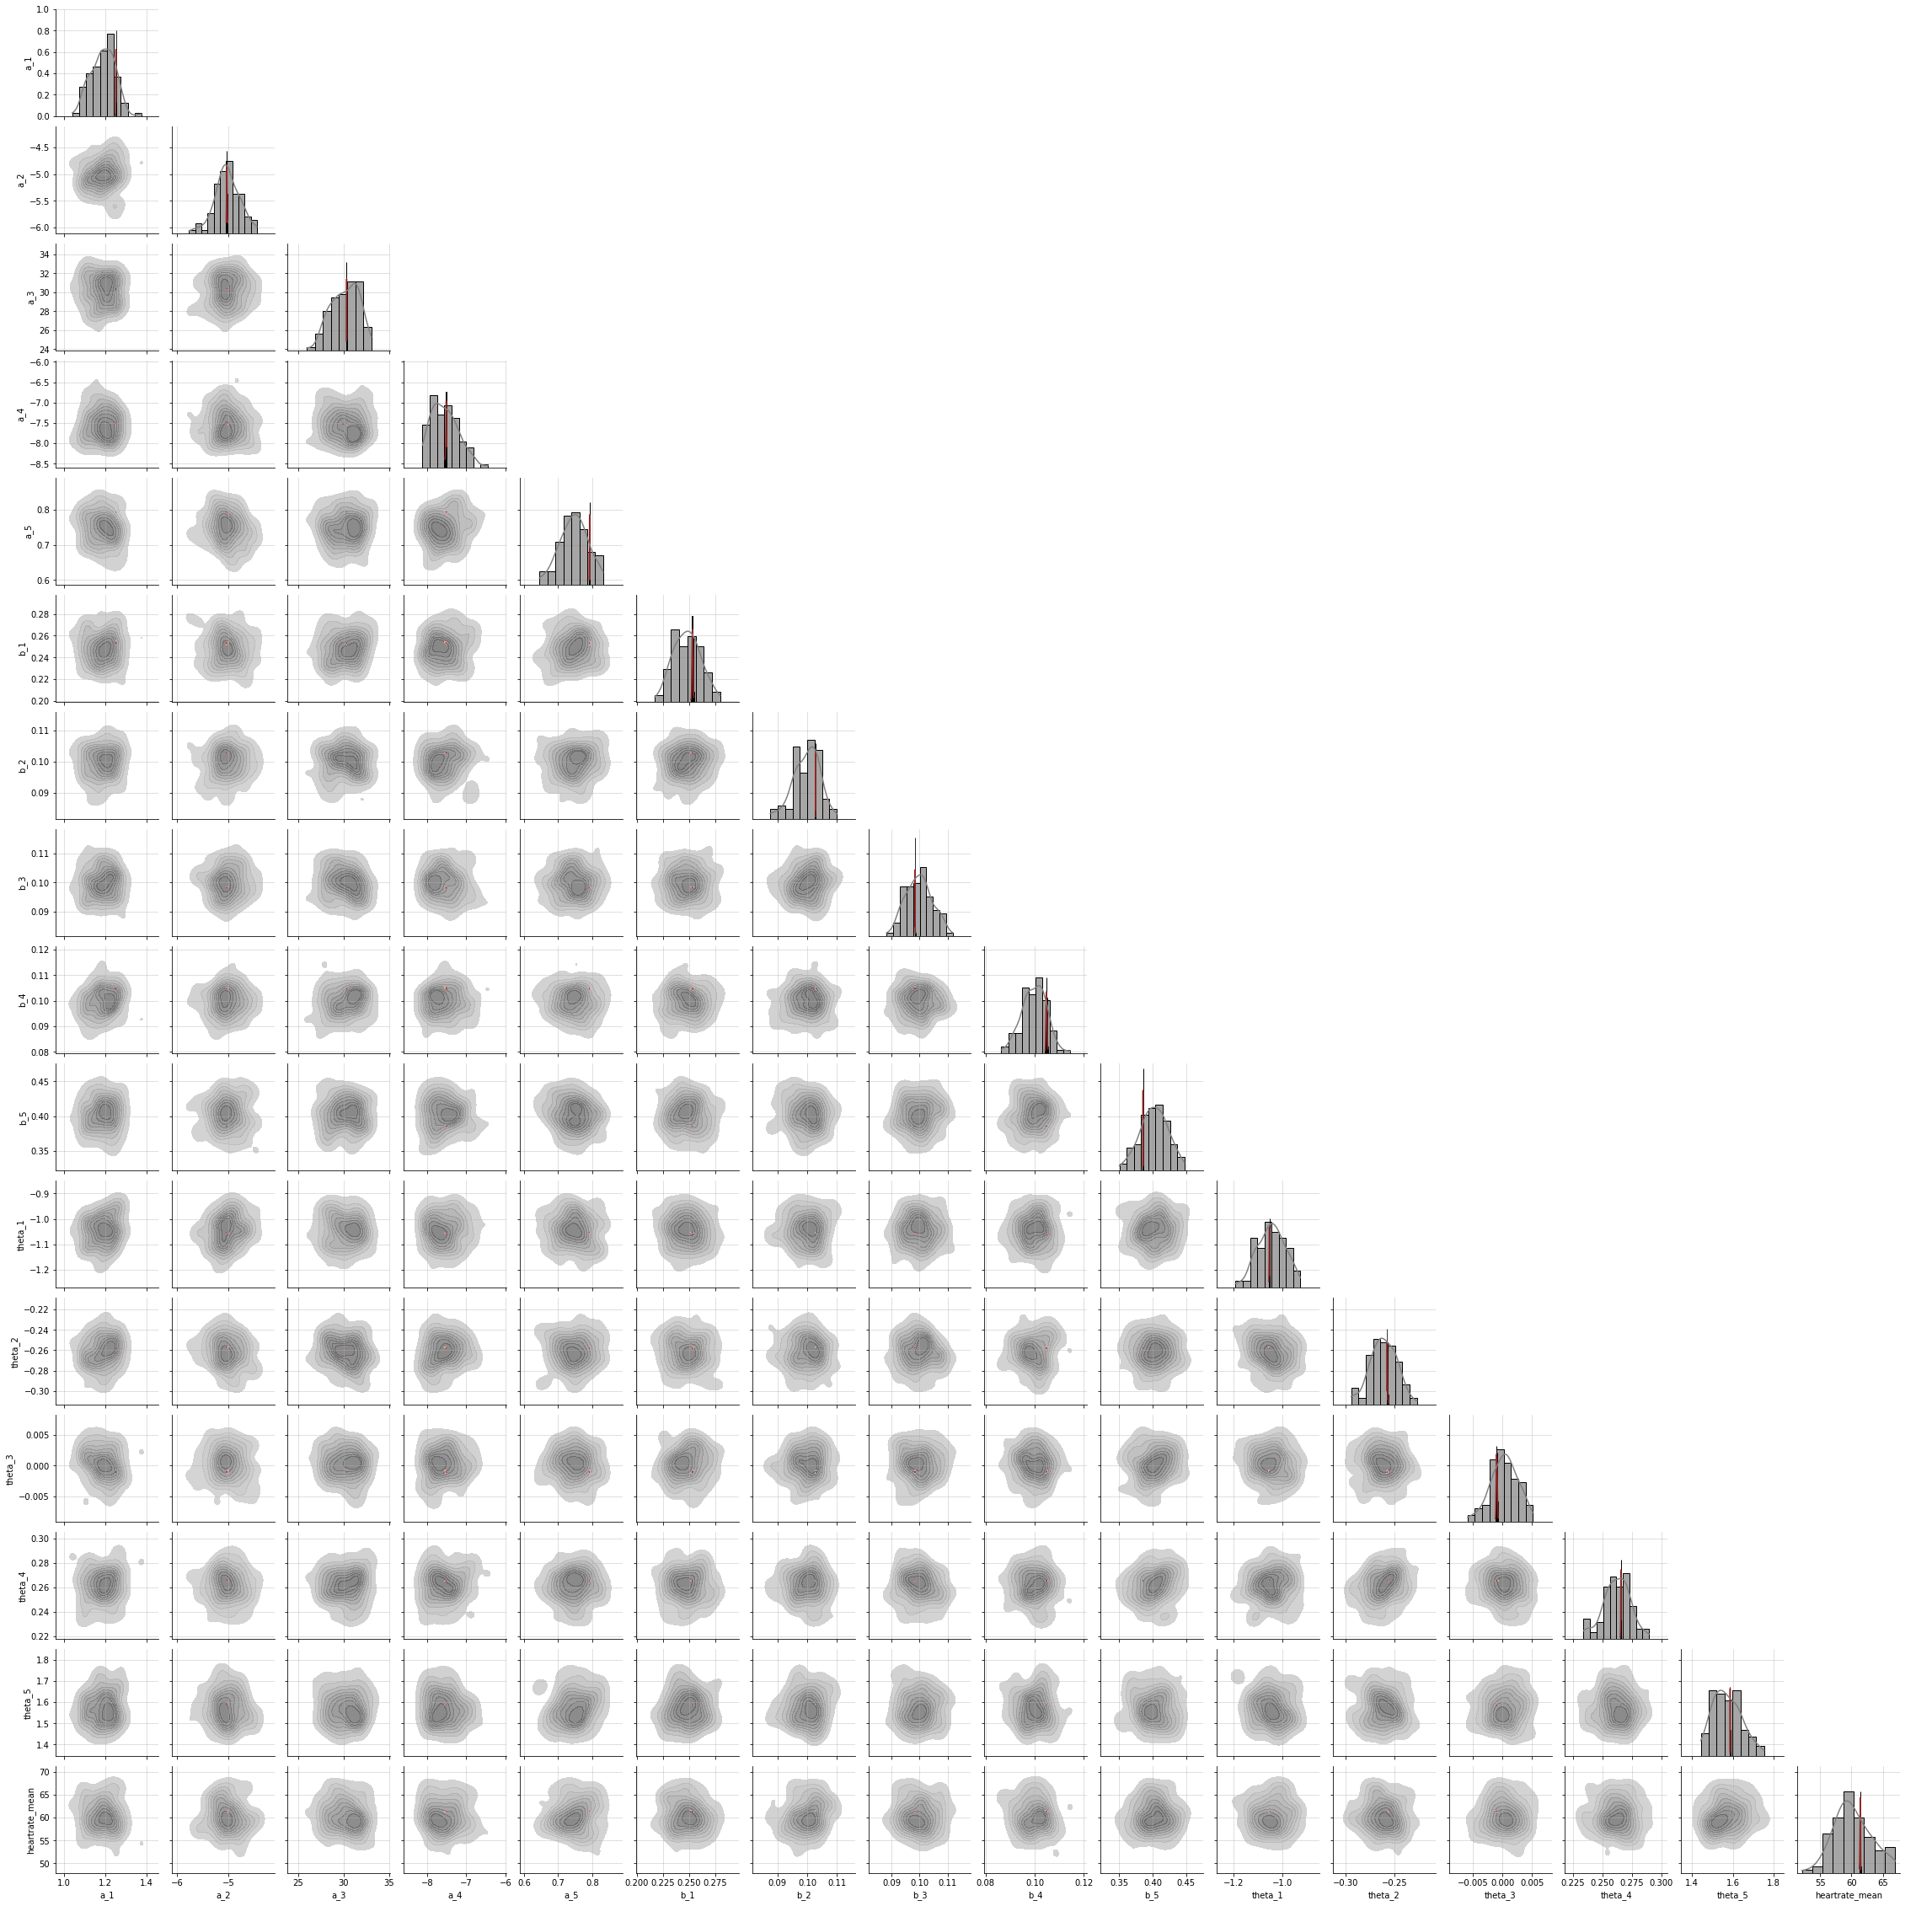

In [29]:
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], prior=prior_ecg)

In [30]:
# # re-simulation
# resim_u = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)
# resim_v = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)

# for i in range(posterior_samples_unnorm[0].shape[0]):
#     re_sim = linear_ode_solver(posterior_samples_unnorm[0, i], time_points)
#     resim_u[i, :] = re_sim[:, 0]
#     resim_v[i, :] = re_sim[:, 1]

# # compute quantiles
# u_qt_50 = np.quantile(resim_u, q=[0.25, 0.75], axis=0)
# u_qt_90 = np.quantile(resim_u, q=[0.05, 0.95], axis=0)
# u_qt_95 = np.quantile(resim_u, q=[0.025, 0.975], axis=0)
# v_qt_50 = np.quantile(resim_v, q=[0.25, 0.75], axis=0)
# v_qt_90 = np.quantile(resim_v, q=[0.05, 0.95], axis=0)
# v_qt_95 = np.quantile(resim_v, q=[0.025, 0.975], axis=0)
    
# # plot u
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# ax.plot(time_points, np.median(resim_u, axis=0), label='Median u(t)', color='b')
# ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :, 0], marker='o', label='Ground truth u(t)', color='k', linestyle='--', alpha=0.8)
# ax.fill_between(time_points, u_qt_50[0], u_qt_50[1], color='b', alpha=0.3, label='50% CI')
# ax.fill_between(time_points, u_qt_90[0], u_qt_90[1], color='b', alpha=0.2, label='90% CI')
# ax.fill_between(time_points, u_qt_95[0], u_qt_95[1], color='b', alpha=0.1, label='95% CI')
# ax.grid(True)
# ax.set_title("Re-simulation for u(t)")
# ax.set_xlabel("Time t [s]")
# ax.set_ylabel("Function u(t)")
# ax.legend()
# plt.show()

# # plot v
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# ax.plot(time_points, np.median(resim_v, axis=0), label='Median v(t)', color='b')
# ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :, 1], marker='o', label='Ground truth v(t)', color='k', linestyle='--', alpha=0.8)
# ax.fill_between(time_points, v_qt_50[0], v_qt_50[1], color='b', alpha=0.3, label='50% CI')
# ax.fill_between(time_points, v_qt_90[0], v_qt_90[1], color='b', alpha=0.2, label='90% CI')
# ax.fill_between(time_points, v_qt_95[0], v_qt_95[1], color='b', alpha=0.1, label='95% CI')
# ax.grid(True)
# ax.set_title("Re-simulation for v(t)")
# ax.set_xlabel("Time t [s]")
# ax.set_ylabel("Function v(t)")
# ax.legend()
# plt.show()

In [31]:
## Offene Fragen
# 1. Welche Parameter sollten variiert werdden (b,theta,a,f_2, Simulation)?
# 2. Wie sollte variiert werden (Verteilung, Streuung)?
# Ziel: Zunächst einmal gesunde Fälle priorisieren. Ggf. mehrere Modelle nutzen (unterschiedliche Pathologien)
# -> Model selection
# Einheit für Periode gleich halten (gleiche Zeitschrittgröße); Signallänge (/Anzahl der Perioden)
# erstmal fix mit CNN, dann mit LSTM variabel

# Weiß man, wie hoch die Rauschamplitude ist? Wenn ja, als Parameter an das NN übergeben

# Kalibrierungsproblemerklärung: zu wenig trainiert, zu kleines Netz

In [32]:
# 1. Adjustable learning rate stärker parametrisierbar (u. an-/abstellbar) machen? (Aktuell zu frühes Stoppen)
# -> Aktuelle Fassung von letzter Woche testen!

# 2. Debugging/Fehlersuche wenn das Modell rät (true vs. estimated horizontal)? Workflow?
# -> Korrelation +/-1 zwischen Komponenten
# -> Info-Verlust im Modell? 
# -> PyABC direkt auf Summary Statistic (Vorsicht, langsam!)
# -> LSTM 500 hidden units für 4-5 Parameter (erst als Regression ohne BayesFlow testen, dann als 
# Summary Net nutzen)
# -> unter der Voraussetzung guter Ergebnisse: pre-trained networks verwenden
# -> Trainings-Tempo: ein paar Tausend Simulationen sollten aussagekräftige Trends liefern
# -> Diagnostik mittels true vs estimated: ggf. Median statt Mittelwert testen

# 3. Summary net: Wahl von n_summary? Größe und Art des Netzes (in Relation zu n_summary/dem Problem)?
# -> >= Anzahl params (e.g. x4)
# -> PCA des summary space (-> überparametrisierter latent space erkennen (Detecting Model Misspecification ... arXiv 2021 (Radev last)))

# 4. Preprocessing (ja/nein, wenn ja was)?
# -> Fokus auf over-/underflow vermeiden (Skalierung)
# -> einzelner Herzschlag ggf unterinformativ
# -> Downsampling
# -> Transformation (e.g. Fourier)

# 5. Nutzung von Kontext-Informationen? (Hilfreich? Wenn ja, wie?)
# -> z.B. sampling frequency
# -> Nützlich, wenn sich Kontext verändert (z.B. zwei verschiedene sampling frequencies je nach Batch)

# 6. Offline-Training ohne dass Memory ausgeht
# -> Loop über Training; ggf Simulationdataset helper_class anpassen


In [33]:
# Zeitabhängige Parameter: erst omega, dann ggf weitere (wirft auch Fragen zu Priors auf) -> super statistics
# Vergleich: segmentiertes Signal ohne super statistics vs. Gesamtsignal mit
# Ggf. anderes Fit-Verfahren als BayesFlow als Baseline (mechanical engineering?)
# Reale Daten -> Simulation gap / model misspecification (später)
# Wunschliste:
# Prior-Veränderung günstig auffangen

In [34]:
# Evaluierung auf separaten Daten